In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import time
import random
# For showing images
from IPython.display import Image

import os
import sys

# Load mavenn
import mavenn


In [2]:
# define different function
from sklearn.utils import shuffle

def LoadData(input,strain):
    df=pd.read_csv(input,sep='\t')
    df=shuffle(df)
    df_strain=df[(df['strain'] ==strain)]
    df_strain['y']= np.log(df_strain['fit'])
    train, test = np.split(df_strain, [int(.8*len(df_strain))]) 
    index = ['val']*int(round(len(train)*0.2)) + ['train']*int(round(len(train)*0.8)) 
    random.shuffle(index)
    train['set']=index
    train = train.reset_index()
    return train, test
def ProduceAA(num,length):
    AA=[]
    AA_ls='ACDEFGHIKLMNPQRSTVWY'
    for i in range(num):
        aa=''.join(random.choice(AA_ls) for x in range(length))
        AA.append(aa)
    AA = pd.Series(AA)
    return AA

def Train_model(train_set,test_set,reg,lr,batch):
    
    L = len(train_set.iloc[0,1])
    model = mavenn.Model(L=L,
                         alphabet='protein',
                         gpmap_type='pairwise', 
                         regression_type='GE',
                         ge_noise_model_type='Gaussian',
                         eta_regularization=0.1,
                         theta_regularization=reg)
    # Set training data
    model.set_data(x=train_set["ID"],
                   y=train_set["y"],
                   validation_flags=(train_set['set']=='val'),
                   shuffle=True)
    
    # Fit model to data
    history = model.fit(learning_rate=lr,
                        epochs=1000,
                        batch_size=batch,
                        early_stopping=True,
                        early_stopping_patience=5,
                        linear_initialization=False)
    return model
def PlotTrain(model,test_set):
    # Get x and y
    x_test = test_set['ID'].values
    y_test = test_set['y'].values

    # Show training history
    print('On test data:')

    # Compute likelihood information
    I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
    print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

    # Compute predictive information
    I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
    print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

    I_var_hist = model.history['I_var']
    val_I_var_hist = model.history['val_I_var']

    fig, ax = plt.subplots(1,2,figsize=[8,4])
    ax[0].plot(I_var_hist, label='I_var_train')
    ax[0].plot(val_I_var_hist, label='I_var_val')
    ax[0].axhline(I_var, color='C2', linestyle=':', label='I_var_test')
    ax[0].axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
    ax[0].legend()
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('bits')
    ax[0].set_title('training hisotry')
    ax[0].set_ylim([0, I_pred*1.2]);

    ax[1].plot(model.history['loss'])
    ax[1].plot(model.history['val_loss'])
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('$\mathcal{L}_{\text{like}}$')

    plt.tight_layout()
    plt.show()
def PlotR2(model,test_set):
    x_test = test_set['ID'].values
    y_test = test_set['y'].values
    # Predict measurement values (yhat) on test data
    yhat_test = model.x_to_yhat(x_test)
    # Compute R^2 between yhat and y_test
    Rsq = np.corrcoef(yhat_test.ravel(), y_test)[0, 1]**2

    # Plot y_test vs. yhat_test
    fig, ax = plt.subplots(1,1)
    ax.scatter(yhat_test, y_test, color='C0', s=10, alpha=.4, label='test data')
    ax.set_xlabel('model prediction ($\hat{y}$)')
    ax.set_ylabel('measurement ($y$)')
    ax.set_title(f'performance ($R^2$={Rsq:.3})')
    plt.show()
def PlotGEnonlinearity(model,test_set):
    x_test = test_set['ID'].values
    y_test = test_set['y'].values
    # Predict latent phentoype values (phi) on test data
    phi_test = model.x_to_phi(x_test)

    # Set phi lims and create grid in phi space
    phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
    phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

    # Compute yhat each phi gridpoint
    yhat_grid = model.phi_to_yhat(phi_grid)

    # Compute 90% CI for each yhat
    q = [0.05, 0.95] #[0.16, 0.84]
    yqs_grid = model.yhat_to_yq(yhat_grid, q=q)

    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=[4, 4])

    # Illustrate measurement process with GE curve
    ax.scatter(phi_test, y_test, color='C0', s=10, alpha=.1, label='test data')
    ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
            label='$\hat{y} = g(\phi)$')
    ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='90% CI')
    ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
    ax.set_xlim(phi_lim)
    ax.set_xlabel('latent phenotype ($\phi$)')
    ax.set_ylabel('measurement ($y$)')
    ax.set_title('measurement process')
    ax.legend()

    # Fix up plot
    fig.tight_layout()
    plt.show()

#epi_map export
def array2df(input):
    colnames=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
    epi_map=pd.DataFrame()
    for i in range(7):
        for j in range(7):
            map = input[i,:,j,:]
            map_df = pd.DataFrame(map,index=colnames,columns=colnames)
            map_df['L1']=[i+1]*20
            map_df['L2']=[j+1]*20
            epi_map = epi_map.append(map_df)
    return epi_map

#reformat the dataframe to L1,L2,aa1,aa2,epi
def df2epimap(input):
    epi_df = pd.DataFrame(columns=["L1","L2","AA1","AA2","EPI"])
    for row_index, row in input.iterrows():
        L1=row['L1']
        L2=row['L2']
        AA1=row_index
        row=row.dropna()
        row=row.drop(labels=['L1', 'L2'])
        for col_index, col in row.items():               
            EPI=col
            AA2=col_index
            add_row = [L1,L2,AA1,AA2,EPI]
            add_series = pd.Series(add_row, index = epi_df.columns)
            epi_df = epi_df.append(add_series,ignore_index=True)
    return epi_df

def reformat(theta_lc):
    colnames=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
    index=[328,329,344,367,368,369,370]
    theta_df = pd.DataFrame(theta_lc,index=index,columns=colnames)
    add_df = pd.DataFrame(columns=["pos","aa","add_fit"])
    for row_index, row in theta_df.iterrows():
        pos=row_index
        row=row.dropna()
        for col_index, col in row.items():               
            add_fit=col
            aa=col_index
            add_row = [pos,aa,add_fit]
            add_series = pd.Series(add_row, index = add_df.columns)
            add_df = add_df.append(add_series,ignore_index=True)
    return add_df

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0192 sec.
Epoch 1/1000
9/9 [==============================] - 0s 21ms/step - loss: 96.7677 - I_var: -0.0159 - val_loss: 92.3678 - val_I_var: -0.0300
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 81.2924 - I_var: 0.1937 - val_loss: 89.4304 - val_I_var: -0.0261
Epoch 3/1000
9/9 [==============================] - 0s 7ms/step - loss: 74.9276 - I_var: 0.3008 - val_loss: 86.0151 - val_I_var: 0.0605
Epoch 4/1000
9/9 [==============================] - 0s 8ms/step - loss: 69.3894 - I_var: 0.4018 - val_loss: 81.4825 - val_I_var: 0.1418
Epoch 5/1000
9/9 [==============================] - 0s 8ms/step - loss: 69.9333 - I_var: 0.3892 - val_loss: 87.3274 - val_I_var: 0.0532
Epoch 6/1000
9/9 [==============================] - 0s 8ms/step - loss: 71.5207 - I_var: 0.3692 - val_loss: 79.1239 - val_I_var: 0.2302
Epoch 7/1000
9/9 [==============================] - 0s 8ms/step 

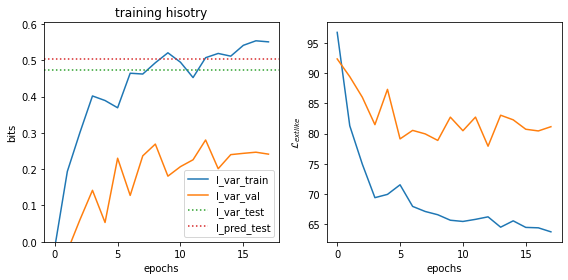

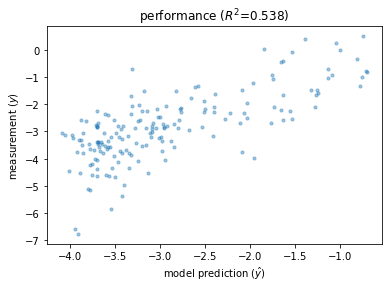

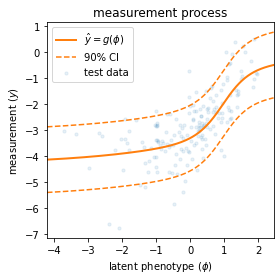

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0203 sec.
Epoch 1/1000
9/9 [==============================] - 0s 26ms/step - loss: 102.3354 - I_var: -0.1834 - val_loss: 82.6995 - val_I_var: 0.0157
Epoch 2/1000
9/9 [==============================] - 0s 8ms/step - loss: 94.2895 - I_var: -0.1330 - val_loss: 78.8981 - val_I_var: 0.0661
Epoch 3/1000
9/9 [==============================] - 0s 8ms/step - loss: 89.1674 - I_var: -0.0596 - val_loss: 79.3738 - val_I_var: 0.1546
Epoch 4/1000
9/9 [==============================] - 0s 8ms/step - loss: 81.7241 - I_var: 0.0982 - val_loss: 69.4713 - val_I_var: 0.3264
Epoch 5/1000
9/9 [==============================] - 0s 7ms/step - loss: 77.7552 - I_var: 0.2161 - val_loss: 68.0852 - val_I_var: 0.3444
Epoch 6/1000
9/9 [==============================] - 0s 8ms/step - loss: 74.6838 - I_var: 0.2758 - val_loss: 67.0590 - val_I_var: 0.3733
Epoch 7/1000
9/9 [==============================] - 0s 8ms/step

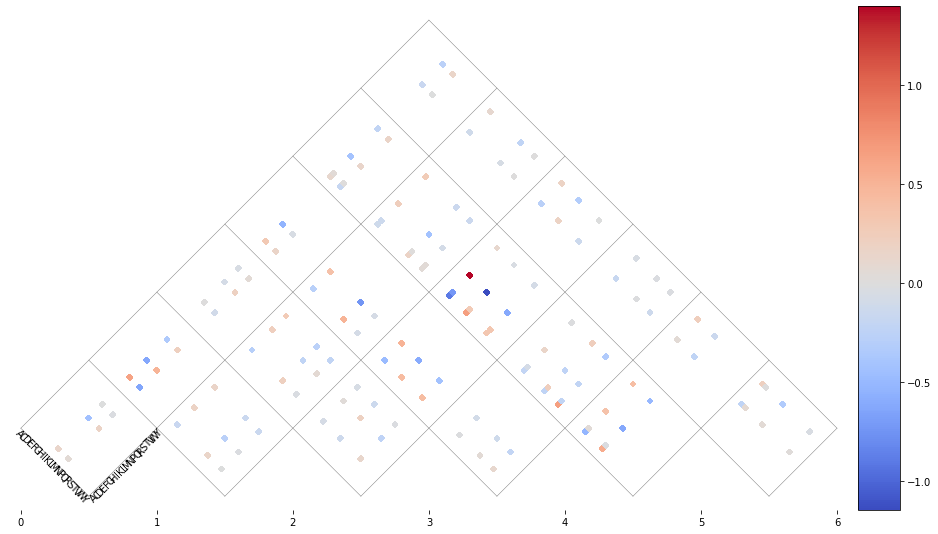

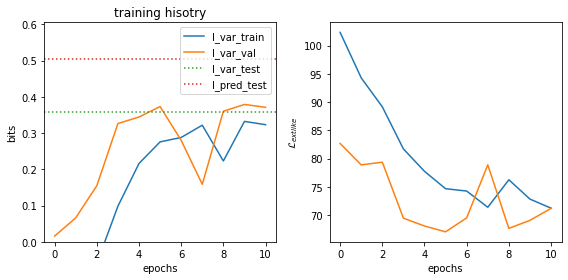

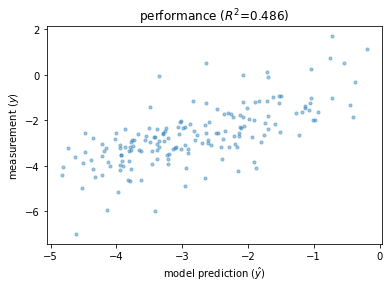

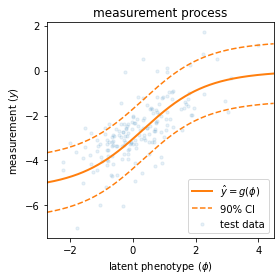

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0197 sec.
Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 115.7544 - I_var: -0.1436 - val_loss: 85.0772 - val_I_var: 0.1575
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 90.0629 - I_var: 0.1269 - val_loss: 73.2722 - val_I_var: 0.2840
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 80.8316 - I_var: 0.2455 - val_loss: 67.9510 - val_I_var: 0.4122
Epoch 4/1000
9/9 [==============================] - 0s 7ms/step - loss: 76.3869 - I_var: 0.3074 - val_loss: 67.7125 - val_I_var: 0.4474
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 72.8568 - I_var: 0.3957 - val_loss: 69.6574 - val_I_var: 0.4077
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 71.4789 - I_var: 0.4148 - val_loss: 67.0798 - val_I_var: 0.4829
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step -

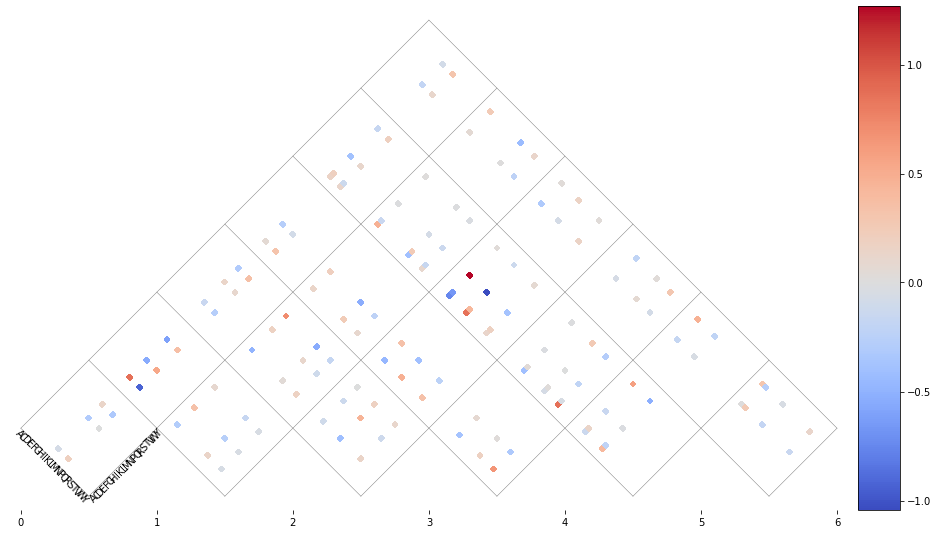

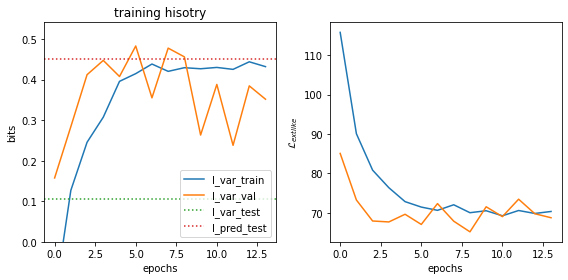

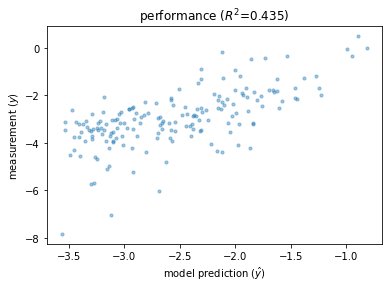

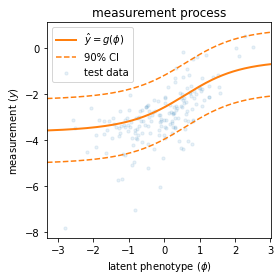

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0162 sec.
Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 114.5660 - I_var: -0.1465 - val_loss: 98.1378 - val_I_var: 0.0678
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 93.2554 - I_var: 0.0163 - val_loss: 79.9506 - val_I_var: 0.1568
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 82.3322 - I_var: 0.1514 - val_loss: 79.0651 - val_I_var: 0.2732
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 74.9827 - I_var: 0.3013 - val_loss: 72.4774 - val_I_var: 0.3092
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 72.1854 - I_var: 0.3753 - val_loss: 75.9734 - val_I_var: 0.1982
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 71.5328 - I_var: 0.4123 - val_loss: 74.0286 - val_I_var: 0.2499
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step -

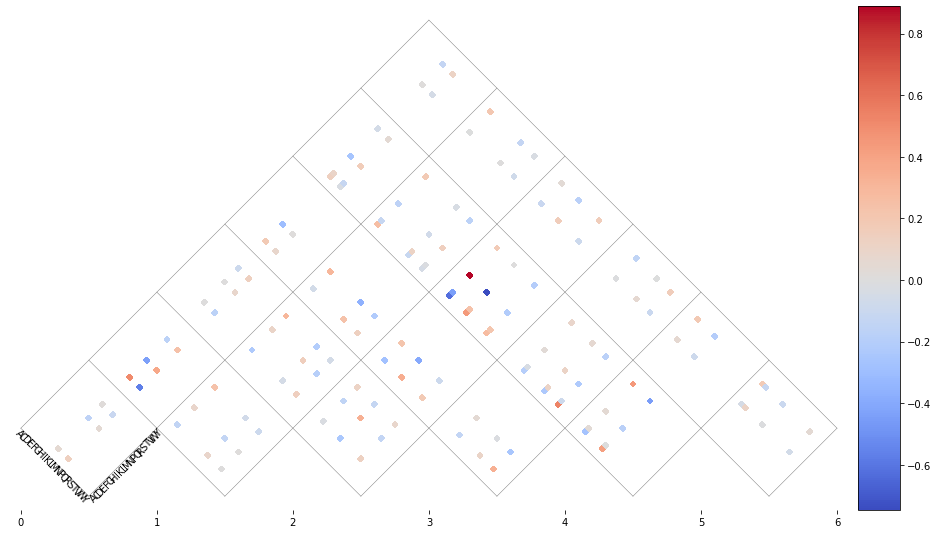

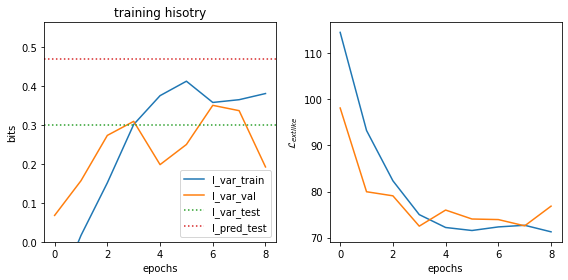

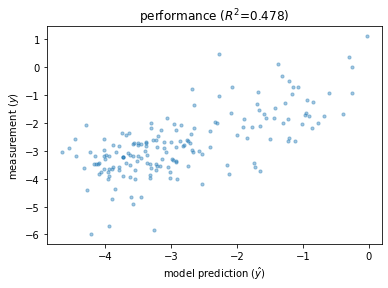

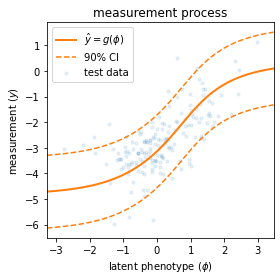

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0169 sec.
Epoch 1/1000
9/9 [==============================] - 0s 19ms/step - loss: 125.0801 - I_var: -0.1023 - val_loss: 95.0883 - val_I_var: -0.1797
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 90.6391 - I_var: 0.1143 - val_loss: 80.8773 - val_I_var: -0.1381
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 79.2293 - I_var: 0.2498 - val_loss: 78.7323 - val_I_var: -0.2105
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 74.3403 - I_var: 0.3467 - val_loss: 79.8037 - val_I_var: -0.1673
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 69.2352 - I_var: 0.4361 - val_loss: 74.5755 - val_I_var: -0.1637
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 70.4389 - I_var: 0.4139 - val_loss: 80.5090 - val_I_var: -0.2303
Epoch 7/1000
9/9 [==============================] - 0s 6ms/

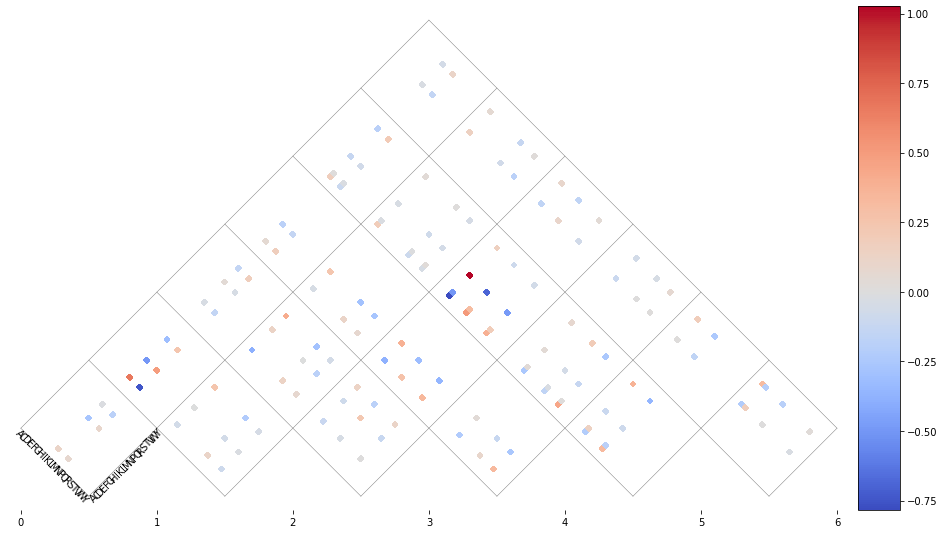

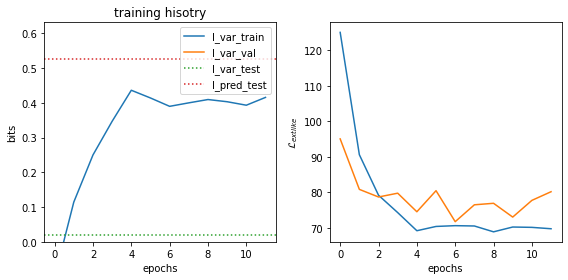

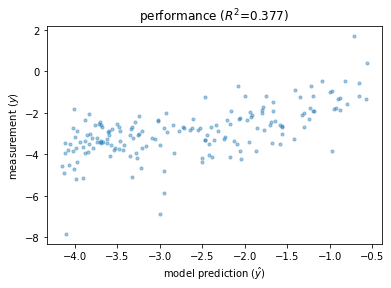

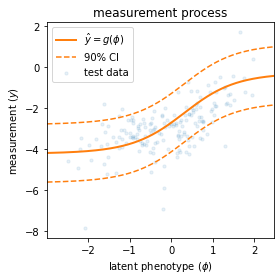

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0156 sec.
Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 126.4787 - I_var: -0.1171 - val_loss: 93.0708 - val_I_var: 0.1977
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 87.1036 - I_var: 0.2143 - val_loss: 77.2057 - val_I_var: 0.3149
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 77.2465 - I_var: 0.3369 - val_loss: 77.1585 - val_I_var: 0.2958
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 73.9230 - I_var: 0.3865 - val_loss: 80.0346 - val_I_var: 0.1258
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 78.0748 - I_var: 0.2779 - val_loss: 73.5696 - val_I_var: 0.3134
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 74.2517 - I_var: 0.3574 - val_loss: 74.6130 - val_I_var: 0.2846
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step -

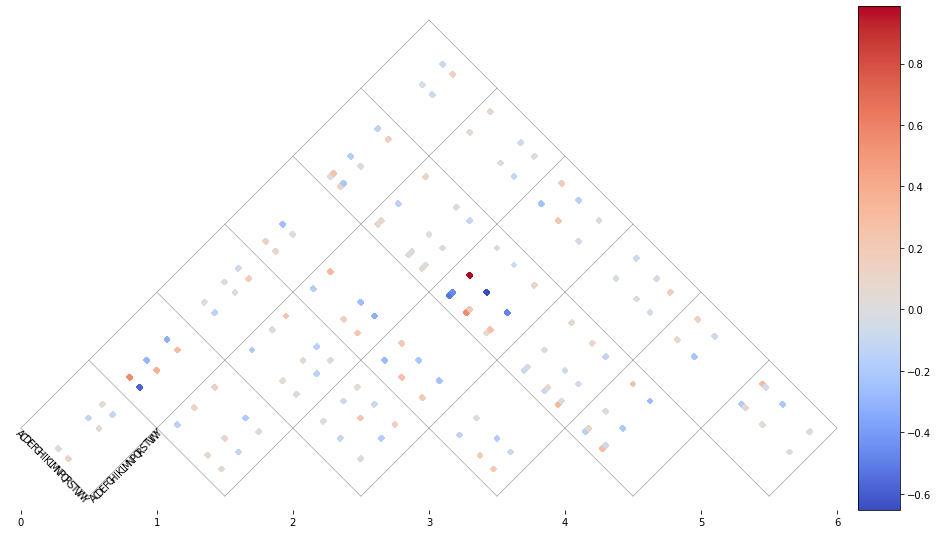

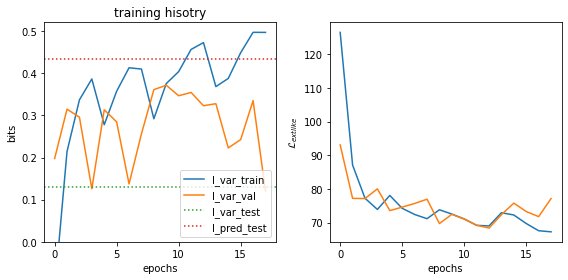

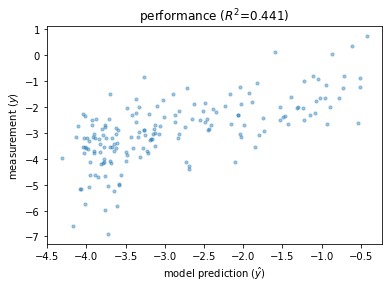

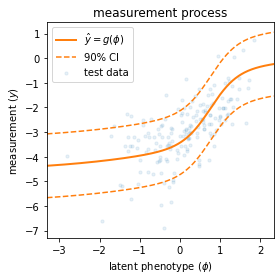

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0186 sec.
Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 144.3994 - I_var: -0.1467 - val_loss: 98.5511 - val_I_var: 0.0440
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 95.9793 - I_var: 0.1175 - val_loss: 78.1489 - val_I_var: 0.2539
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 80.4519 - I_var: 0.2587 - val_loss: 68.6808 - val_I_var: 0.3999
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 75.3626 - I_var: 0.3684 - val_loss: 70.3820 - val_I_var: 0.4275
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 77.4944 - I_var: 0.2930 - val_loss: 68.4922 - val_I_var: 0.4583
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 77.2421 - I_var: 0.2849 - val_loss: 75.5085 - val_I_var: 0.2049
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step -

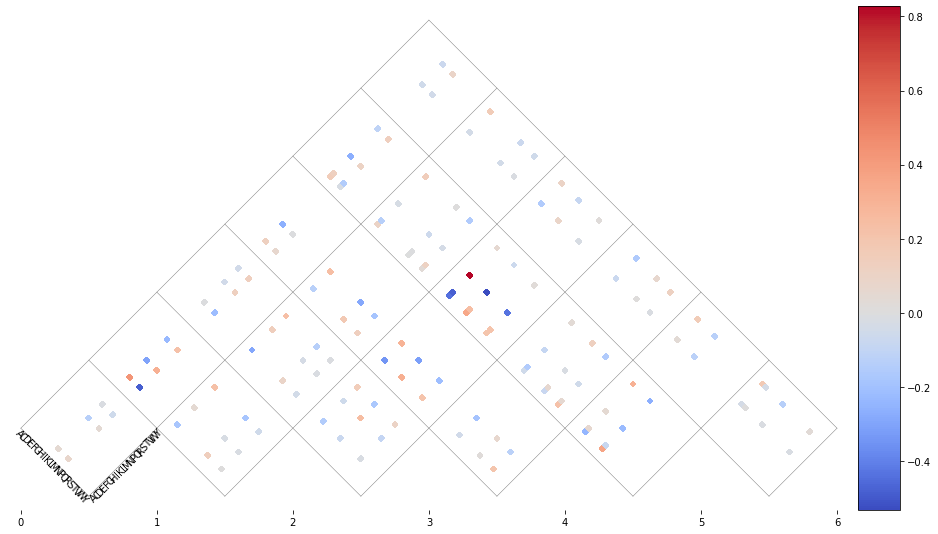

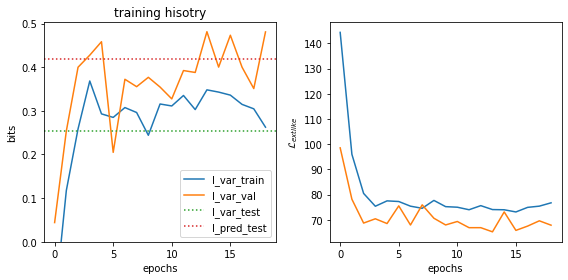

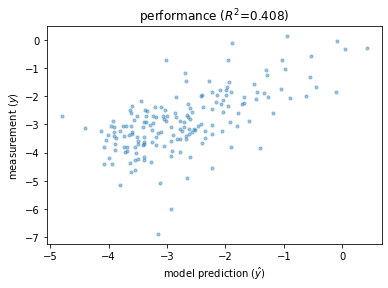

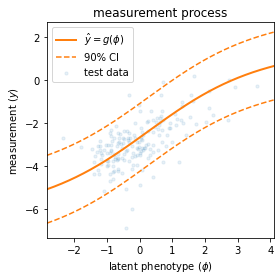

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0159 sec.
Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 142.0924 - I_var: -0.0770 - val_loss: 99.5413 - val_I_var: 0.1641
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 93.9894 - I_var: 0.1935 - val_loss: 80.3335 - val_I_var: 0.2486
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 80.3413 - I_var: 0.2555 - val_loss: 84.2613 - val_I_var: 0.1524
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 80.5238 - I_var: 0.2556 - val_loss: 77.1934 - val_I_var: 0.2459
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 78.5483 - I_var: 0.2695 - val_loss: 77.4441 - val_I_var: 0.2494
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 75.7360 - I_var: 0.3282 - val_loss: 76.5675 - val_I_var: 0.2423
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step -

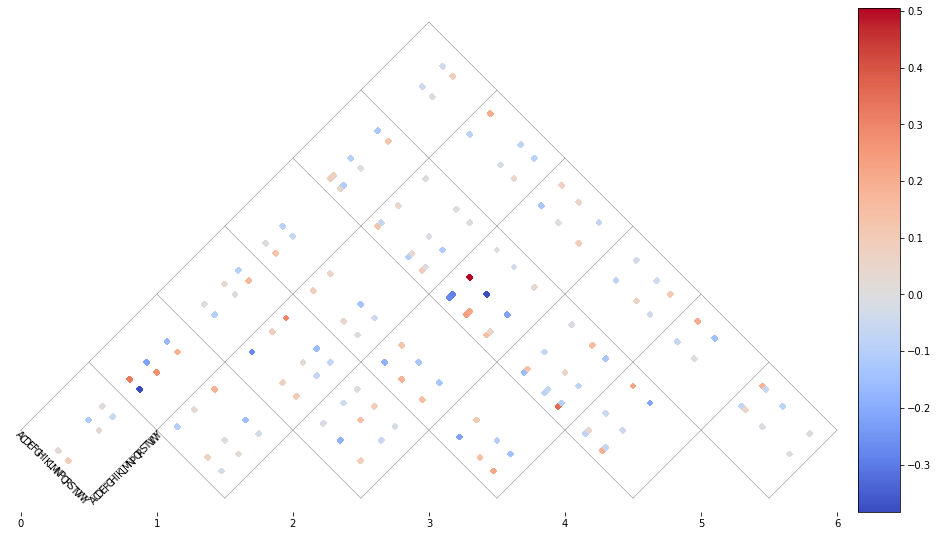

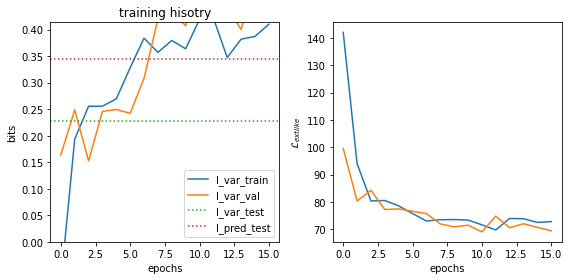

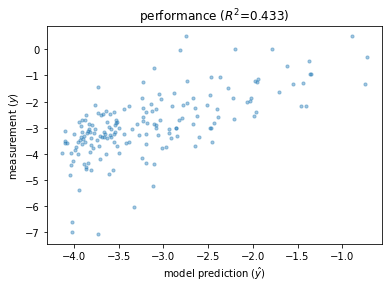

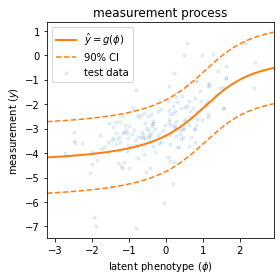

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0164 sec.
Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 155.5686 - I_var: -0.0976 - val_loss: 123.2862 - val_I_var: -0.1398
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 104.9010 - I_var: 0.0236 - val_loss: 93.9897 - val_I_var: 0.2108
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 84.9368 - I_var: 0.2464 - val_loss: 87.6133 - val_I_var: 0.3024
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 79.9630 - I_var: 0.2433 - val_loss: 89.7397 - val_I_var: 0.2677
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 75.0548 - I_var: 0.3263 - val_loss: 84.3236 - val_I_var: 0.3092
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 76.8920 - I_var: 0.3007 - val_loss: 80.2993 - val_I_var: 0.3768
Epoch 7/1000
9/9 [==============================] - 0s 6ms/ste

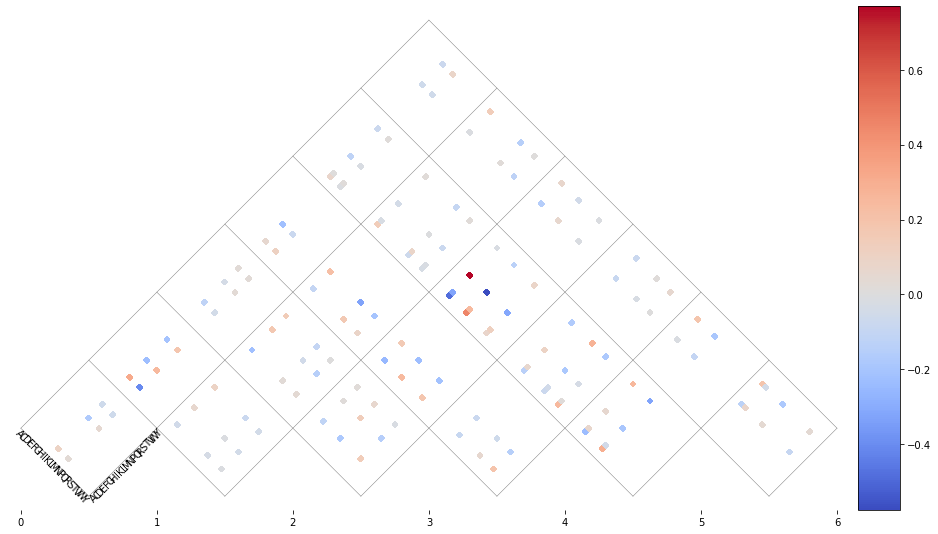

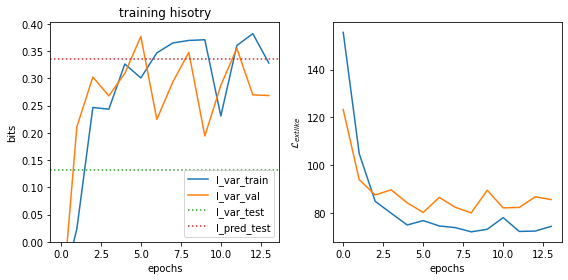

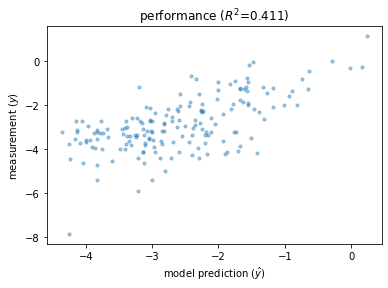

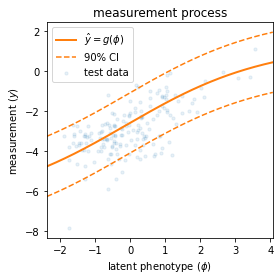

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0168 sec.
Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 155.3143 - I_var: -0.0469 - val_loss: 113.8311 - val_I_var: -0.0197
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 101.0593 - I_var: 0.1266 - val_loss: 82.8382 - val_I_var: 0.3427
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 84.4631 - I_var: 0.2443 - val_loss: 78.7811 - val_I_var: 0.3691
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 76.1146 - I_var: 0.3557 - val_loss: 80.2687 - val_I_var: 0.3759
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 75.2075 - I_var: 0.3329 - val_loss: 81.7339 - val_I_var: 0.2235
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 77.6801 - I_var: 0.2973 - val_loss: 78.0858 - val_I_var: 0.2396
Epoch 7/1000
9/9 [==============================] - 0s 6ms/ste

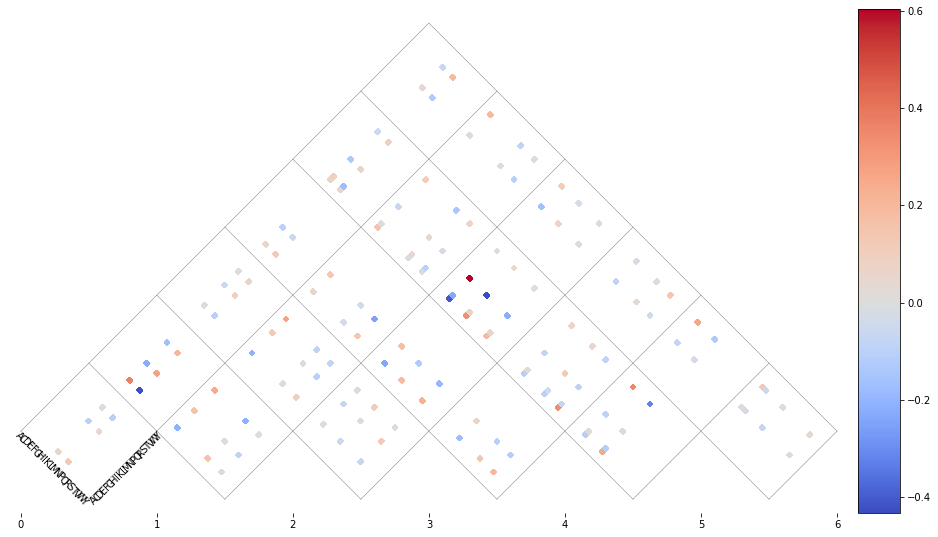

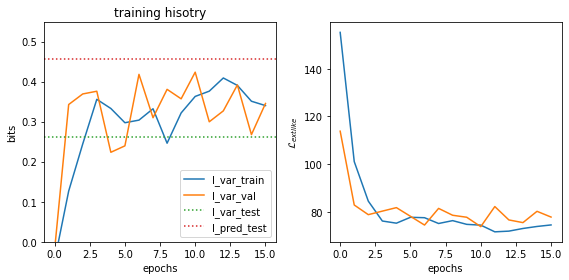

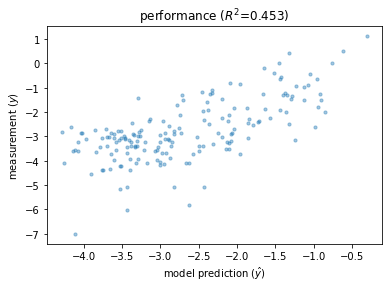

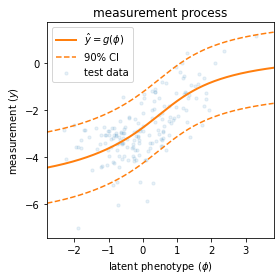

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0169 sec.
Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 162.4330 - I_var: -0.0080 - val_loss: 115.7241 - val_I_var: -0.0780
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 101.5182 - I_var: 0.1715 - val_loss: 91.1927 - val_I_var: 0.0104
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 83.6267 - I_var: 0.2560 - val_loss: 88.3329 - val_I_var: -0.2962
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 82.2043 - I_var: 0.2298 - val_loss: 83.2571 - val_I_var: -0.0844
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 78.5507 - I_var: 0.2688 - val_loss: 74.7801 - val_I_var: 0.2034
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 74.1481 - I_var: 0.3348 - val_loss: 78.4762 - val_I_var: -0.0239
Epoch 7/1000
9/9 [==============================] - 0s 7ms/

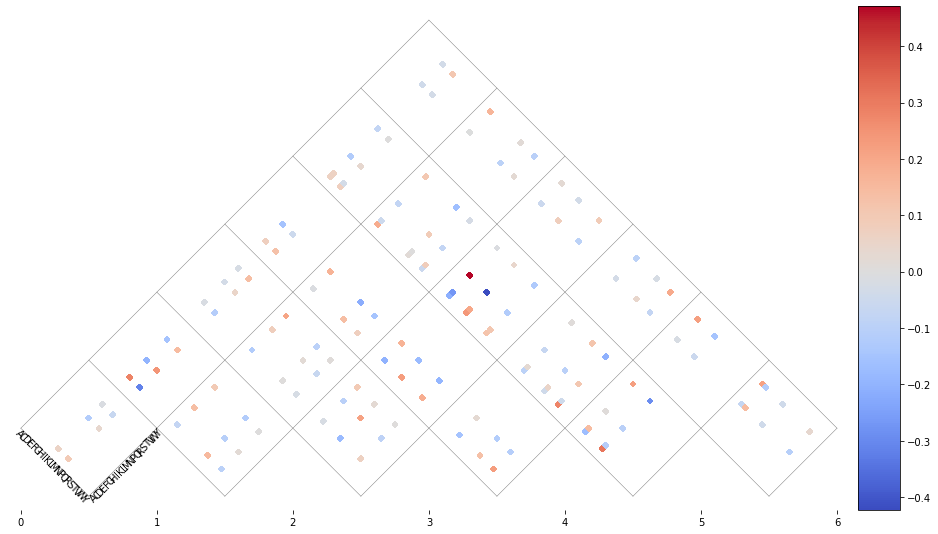

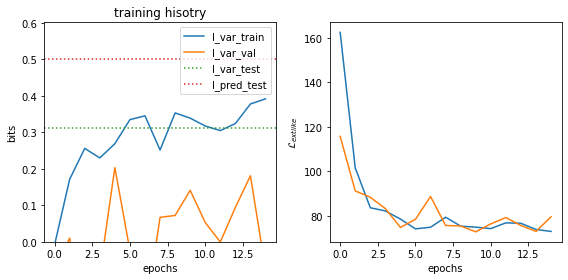

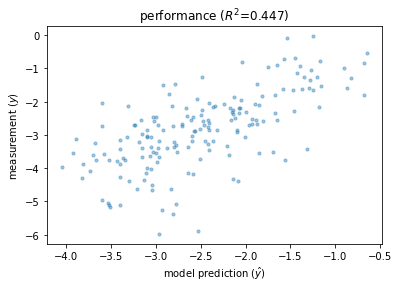

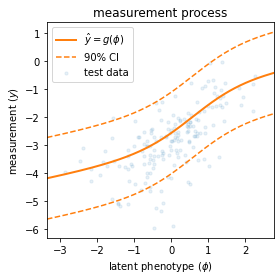

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0163 sec.
Epoch 1/1000
9/9 [==============================] - 0s 21ms/step - loss: 162.5470 - I_var: 0.0386 - val_loss: 114.5084 - val_I_var: -0.0588
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 99.1552 - I_var: 0.2813 - val_loss: 97.4712 - val_I_var: -0.1090
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 82.8079 - I_var: 0.3301 - val_loss: 97.8663 - val_I_var: -0.0510
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 77.8359 - I_var: 0.3712 - val_loss: 89.3743 - val_I_var: -0.0413
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 74.8887 - I_var: 0.3948 - val_loss: 87.4446 - val_I_var: 0.0770
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 76.2744 - I_var: 0.3321 - val_loss: 96.6967 - val_I_var: -0.0048
Epoch 7/1000
9/9 [==============================] - 0s 7ms/s

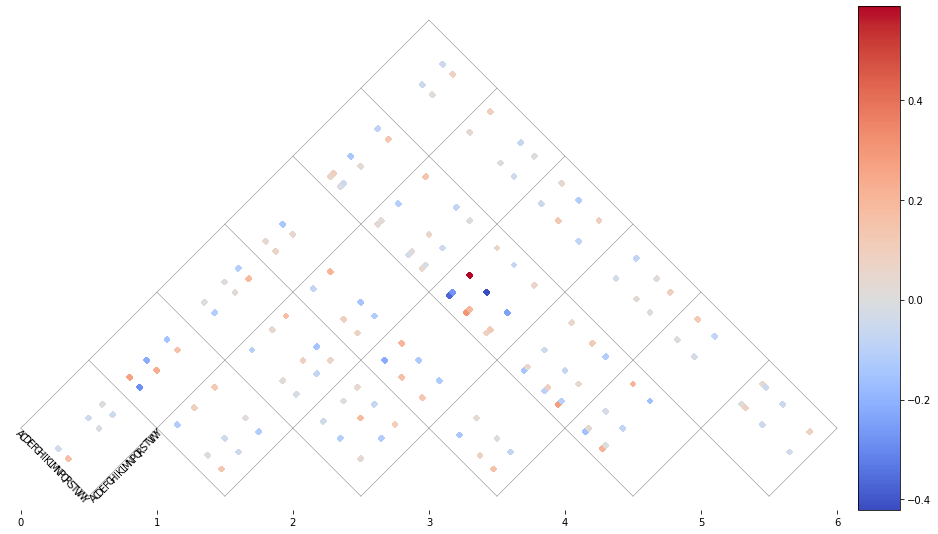

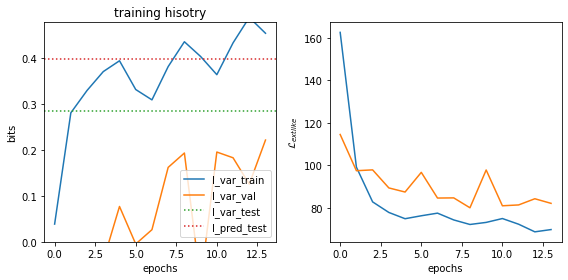

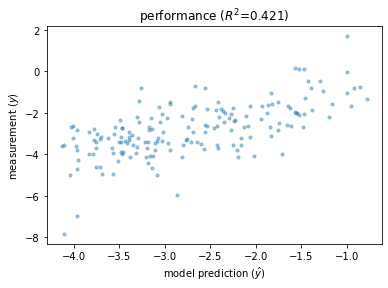

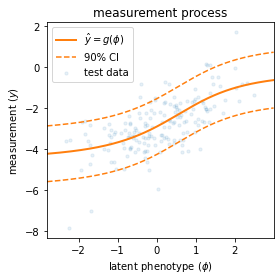

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0155 sec.
Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 185.6439 - I_var: -0.1470 - val_loss: 118.9131 - val_I_var: 0.0654
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 106.7442 - I_var: 0.0787 - val_loss: 91.9747 - val_I_var: 0.1791
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 85.4658 - I_var: 0.2170 - val_loss: 82.3675 - val_I_var: 0.3459
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 80.6041 - I_var: 0.2585 - val_loss: 83.1933 - val_I_var: 0.2685
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 76.6987 - I_var: 0.2615 - val_loss: 79.0659 - val_I_var: 0.3295
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 76.0867 - I_var: 0.2821 - val_loss: 74.9900 - val_I_var: 0.3348
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step

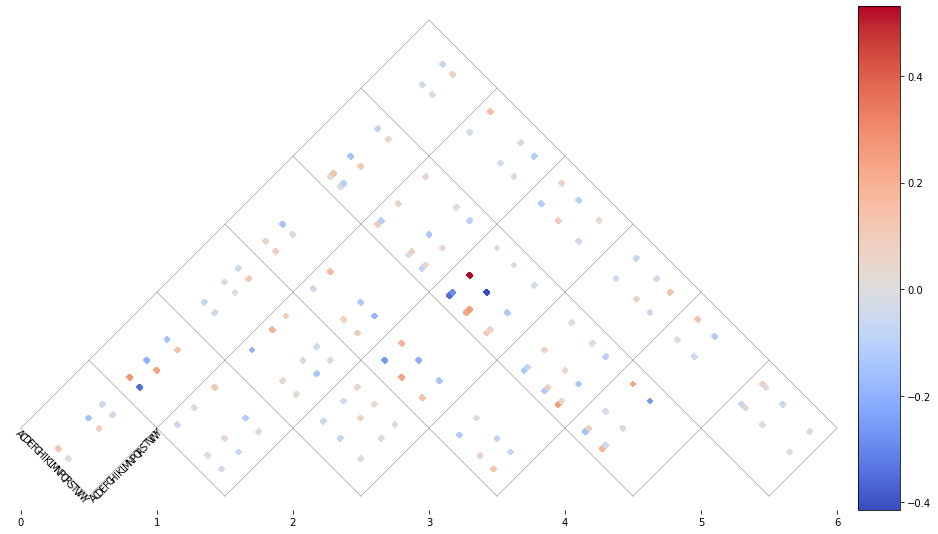

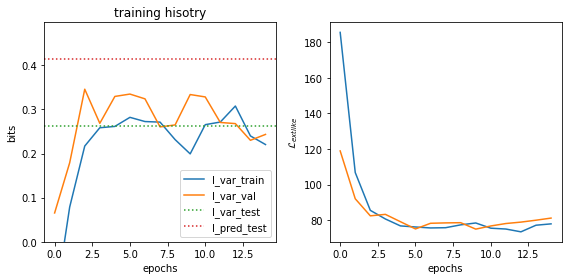

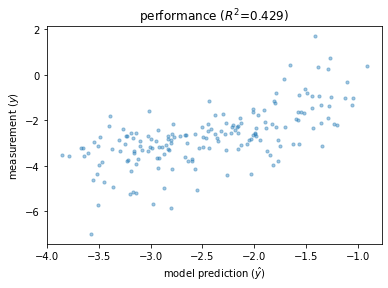

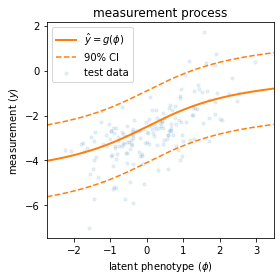

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0169 sec.
Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 183.4934 - I_var: 0.0020 - val_loss: 113.9643 - val_I_var: 0.1934
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 103.6652 - I_var: 0.2319 - val_loss: 89.7500 - val_I_var: 0.2109
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 85.0484 - I_var: 0.3282 - val_loss: 82.6188 - val_I_var: 0.2948
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 84.5437 - I_var: 0.2364 - val_loss: 81.5581 - val_I_var: 0.1509
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 77.5893 - I_var: 0.3323 - val_loss: 81.5167 - val_I_var: 0.2617
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 77.2500 - I_var: 0.2930 - val_loss: 78.5188 - val_I_var: 0.2573
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step 

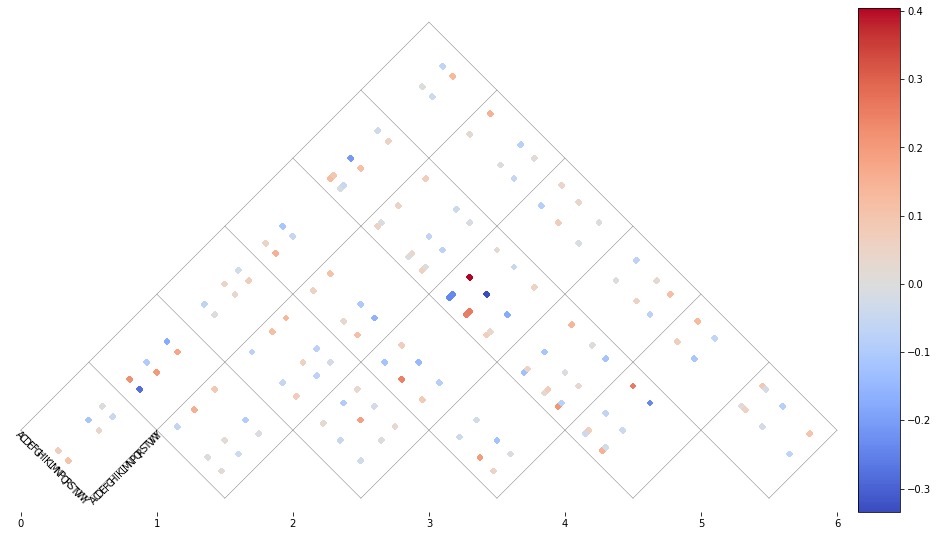

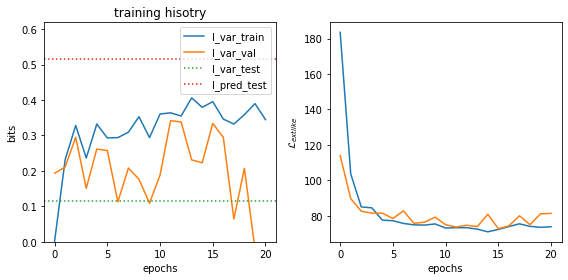

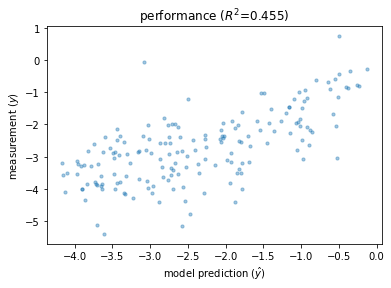

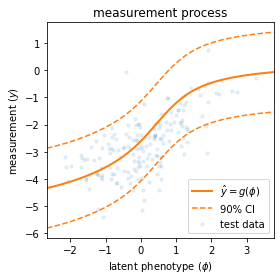

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0151 sec.
Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 193.6090 - I_var: 0.0308 - val_loss: 129.7055 - val_I_var: 0.0791
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 108.2249 - I_var: 0.1962 - val_loss: 102.7289 - val_I_var: 0.0573
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 87.1457 - I_var: 0.2768 - val_loss: 101.5657 - val_I_var: 0.0020
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 81.7736 - I_var: 0.3008 - val_loss: 86.0456 - val_I_var: 0.1815
Epoch 5/1000
9/9 [==============================] - 0s 7ms/step - loss: 75.3258 - I_var: 0.4023 - val_loss: 88.5267 - val_I_var: 0.1111
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 73.9281 - I_var: 0.3633 - val_loss: 83.8592 - val_I_var: 0.1305
Epoch 7/1000
9/9 [==============================] - 0s 6ms/ste

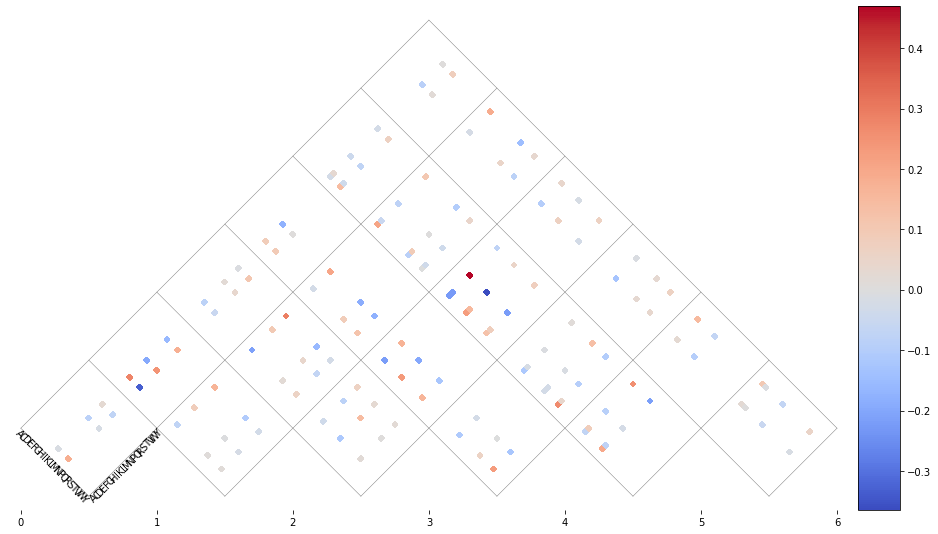

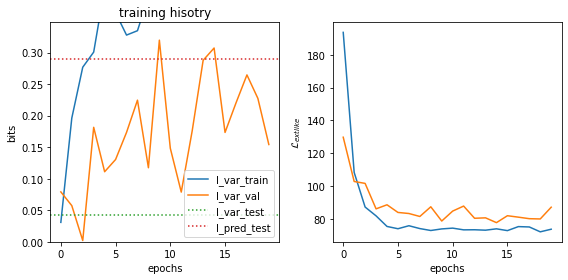

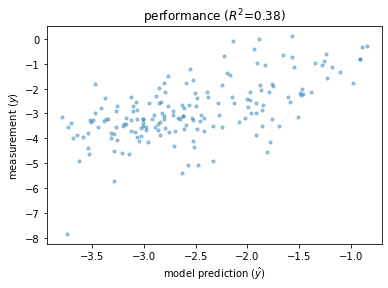

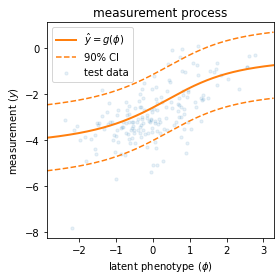

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0167 sec.
Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 201.1934 - I_var: -0.1492 - val_loss: 123.3154 - val_I_var: -0.1206
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 117.5295 - I_var: -0.0615 - val_loss: 88.4875 - val_I_var: 0.0125
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 91.6357 - I_var: 0.1158 - val_loss: 81.0787 - val_I_var: 0.1147
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 83.6168 - I_var: 0.2332 - val_loss: 73.0796 - val_I_var: 0.2222
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 83.3866 - I_var: 0.2133 - val_loss: 78.5354 - val_I_var: 0.1584
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 79.7388 - I_var: 0.2832 - val_loss: 71.0417 - val_I_var: 0.2480
Epoch 7/1000
9/9 [==============================] - 0s 6ms/st

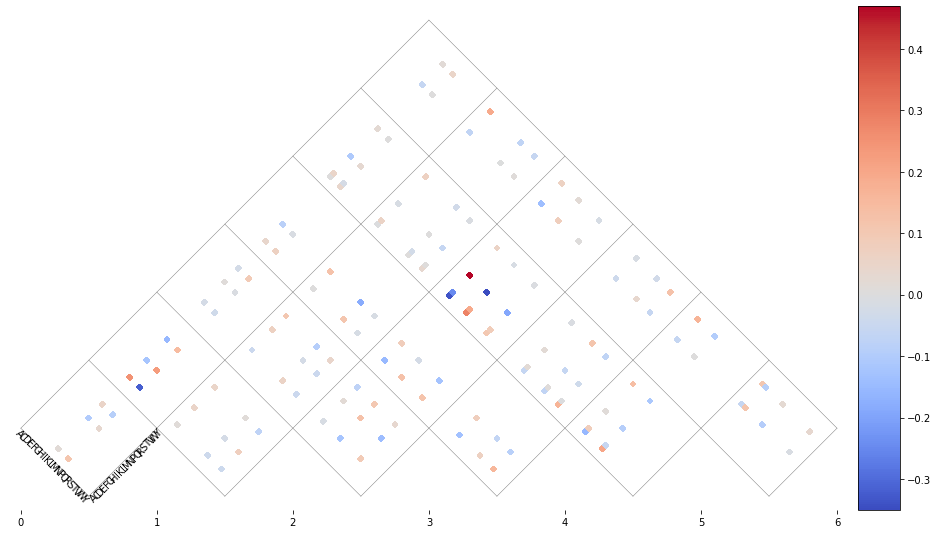

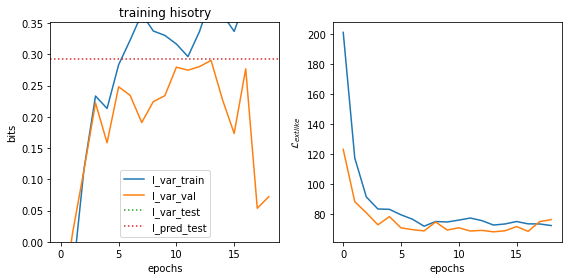

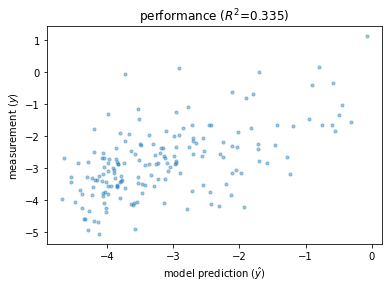

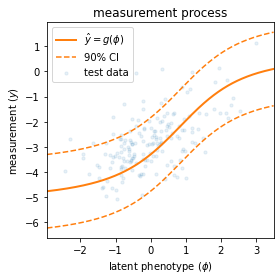

[[0.7889458 ]
 [0.88846986]
 [0.92972476]
 [0.97017526]
 [0.93895152]
 [0.96210107]
 [0.96830739]
 [0.90658203]]
[[0.79580731]
 [0.91117694]
 [0.92414496]
 [0.85638841]
 [0.84685041]
 [0.84345468]
 [0.84328953]
 [0.83244217]]


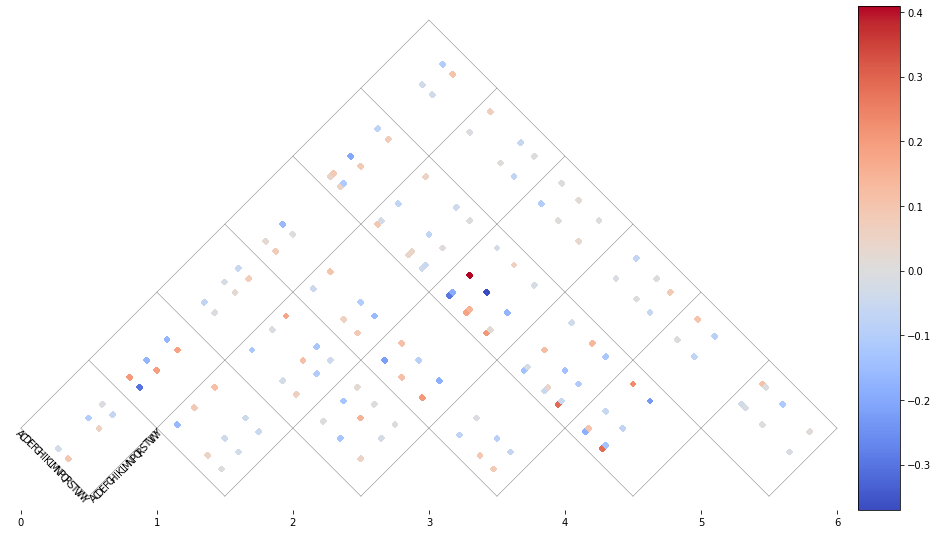

In [20]:
#Find the best regularization for additive fitness(regularization)
reg_ls=[1e-1,3e-1,5e-1,8e-1,1,1.2,1.5,1.7]
add=np.zeros((8,1))
epi=np.zeros((8,1))
R2=np.zeros((19,2))
R2_epi=np.zeros((153,2))
for reg in reg_ls:
    for rep in [0,1]:
        train_set, test_set = LoadData('../result/NA_compile_results.tsv','HK68') 
        model = Train_model(train_set,test_set,reg,0.05,64)
        PlotTrain(model,test_set)
        PlotR2(model,test_set)
        PlotGEnonlinearity(model,test_set)
        theta = model.get_theta()
        fig, ax = plt.subplots(1, 1, figsize=[16, 10])          
        mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
        theta_lc=theta['theta_lc']
        data = theta['theta_lclc']
        epi_map=array2df(data)
        epi_map=epi_map.dropna(thresh=3)
        epi_df = df2epimap(epi_map)
        
        add_df=reformat(theta_lc)
        R2[:,rep]=add_df['add_fit']
        R2_epi[:,rep]=epi_df['EPI']
    R = np.corrcoef(R2[:,0], R2[:,1])[0, 1]
    R_epi = np.corrcoef(R2_epi[:,0], R2_epi[:,1])[0, 1]
    index = reg_ls.index(reg)
    add[index,0]=R
    epi[index,0]=R_epi
print(add)   
print(epi)
 

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0208 sec.
Epoch 1/1000
9/9 [==============================] - 0s 21ms/step - loss: 249.8177 - I_var: -0.1982 - val_loss: 237.5917 - val_I_var: -0.2281
Epoch 2/1000
9/9 [==============================] - 0s 8ms/step - loss: 232.9117 - I_var: -0.1120 - val_loss: 223.8167 - val_I_var: -0.1668
Epoch 3/1000
9/9 [==============================] - 0s 8ms/step - loss: 219.2728 - I_var: -0.0945 - val_loss: 211.7511 - val_I_var: -0.1425
Epoch 4/1000
9/9 [==============================] - 0s 8ms/step - loss: 207.6745 - I_var: -0.0732 - val_loss: 200.3685 - val_I_var: -0.1233
Epoch 5/1000
9/9 [==============================] - 0s 7ms/step - loss: 196.5605 - I_var: -0.0468 - val_loss: 189.1783 - val_I_var: -0.0954
Epoch 6/1000
9/9 [==============================] - 0s 8ms/step - loss: 185.8107 - I_var: -0.0123 - val_loss: 178.4692 - val_I_var: -0.0488
Epoch 7/1000
9/9 [=========================

9/9 [==============================] - 0s 7ms/step - loss: 44.6220 - I_var: 1.0781 - val_loss: 43.1327 - val_I_var: 1.0764
Epoch 60/1000
9/9 [==============================] - 0s 7ms/step - loss: 43.9377 - I_var: 1.0836 - val_loss: 42.6322 - val_I_var: 1.0796
Epoch 61/1000
9/9 [==============================] - 0s 7ms/step - loss: 43.1960 - I_var: 1.0931 - val_loss: 42.1133 - val_I_var: 1.0905
Epoch 62/1000
9/9 [==============================] - 0s 7ms/step - loss: 42.6328 - I_var: 1.1021 - val_loss: 41.5715 - val_I_var: 1.0965
Epoch 63/1000
9/9 [==============================] - 0s 7ms/step - loss: 42.2809 - I_var: 1.1189 - val_loss: 41.1681 - val_I_var: 1.1022
Epoch 64/1000
9/9 [==============================] - 0s 7ms/step - loss: 41.7126 - I_var: 1.1282 - val_loss: 40.7567 - val_I_var: 1.1064
Epoch 65/1000
9/9 [==============================] - 0s 8ms/step - loss: 41.1203 - I_var: 1.1377 - val_loss: 40.4102 - val_I_var: 1.1150
Epoch 66/1000
9/9 [==============================] - 0s

Epoch 119/1000
9/9 [==============================] - 0s 6ms/step - loss: 19.5571 - I_var: 1.5613 - val_loss: 27.4446 - val_I_var: 1.4033
Epoch 120/1000
9/9 [==============================] - 0s 6ms/step - loss: 19.2366 - I_var: 1.5713 - val_loss: 27.7340 - val_I_var: 1.3995
Epoch 121/1000
9/9 [==============================] - 0s 6ms/step - loss: 18.9822 - I_var: 1.5882 - val_loss: 28.5333 - val_I_var: 1.3841
Epoch 122/1000
9/9 [==============================] - 0s 6ms/step - loss: 18.0636 - I_var: 1.5638 - val_loss: 27.3488 - val_I_var: 1.4042
Epoch 123/1000
9/9 [==============================] - 0s 6ms/step - loss: 18.6586 - I_var: 1.5955 - val_loss: 27.6370 - val_I_var: 1.4016
Epoch 124/1000
9/9 [==============================] - 0s 6ms/step - loss: 18.7294 - I_var: 1.5836 - val_loss: 27.7782 - val_I_var: 1.3962
Epoch 125/1000
9/9 [==============================] - 0s 6ms/step - loss: 18.3696 - I_var: 1.5902 - val_loss: 28.0212 - val_I_var: 1.4033
Epoch 126/1000
9/9 [==============

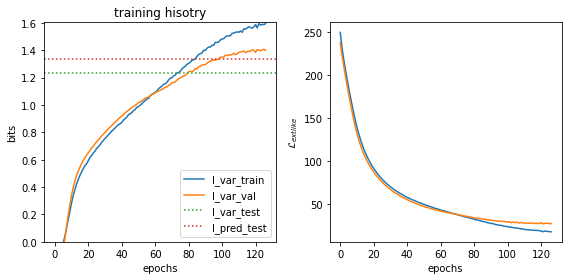

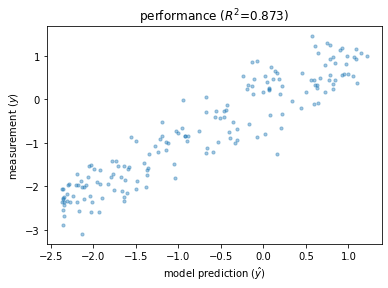

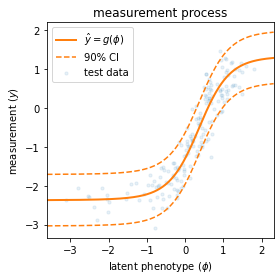

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0162 sec.
Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 248.8496 - I_var: -0.3819 - val_loss: 235.6716 - val_I_var: -0.1951
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 228.6133 - I_var: -0.2368 - val_loss: 219.7564 - val_I_var: -0.1195
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 214.1912 - I_var: -0.1785 - val_loss: 207.1616 - val_I_var: -0.0910
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 202.5853 - I_var: -0.1524 - val_loss: 196.4141 - val_I_var: -0.0781
Epoch 5/1000
9/9 [==============================] - 0s 7ms/step - loss: 192.4513 - I_var: -0.1404 - val_loss: 186.9772 - val_I_var: -0.0713
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 183.4393 - I_var: -0.1316 - val_loss: 178.5138 - val_I_var: -0.0656
Epoch 7/1000
9/9 [=========================

9/9 [==============================] - 0s 7ms/step - loss: 43.0177 - I_var: 1.0791 - val_loss: 45.7819 - val_I_var: 1.0299
Epoch 60/1000
9/9 [==============================] - 0s 6ms/step - loss: 42.2921 - I_var: 1.0820 - val_loss: 45.3182 - val_I_var: 1.0335
Epoch 61/1000
9/9 [==============================] - 0s 6ms/step - loss: 41.7554 - I_var: 1.0961 - val_loss: 45.0035 - val_I_var: 1.0429
Epoch 62/1000
9/9 [==============================] - 0s 7ms/step - loss: 41.0463 - I_var: 1.1025 - val_loss: 44.5818 - val_I_var: 1.0512
Epoch 63/1000
9/9 [==============================] - 0s 6ms/step - loss: 40.6982 - I_var: 1.1179 - val_loss: 44.0585 - val_I_var: 1.0581
Epoch 64/1000
9/9 [==============================] - 0s 6ms/step - loss: 40.2512 - I_var: 1.1316 - val_loss: 43.6848 - val_I_var: 1.0697
Epoch 65/1000
9/9 [==============================] - 0s 6ms/step - loss: 39.5616 - I_var: 1.1340 - val_loss: 43.3528 - val_I_var: 1.0818
Epoch 66/1000
9/9 [==============================] - 0s

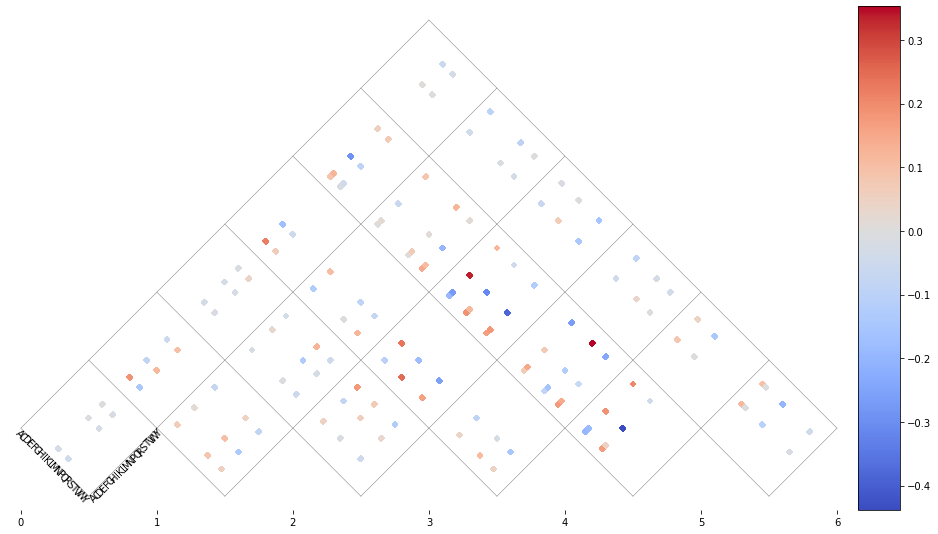

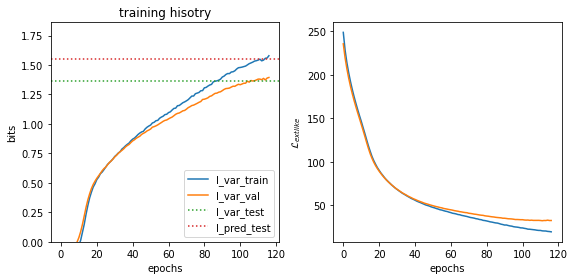

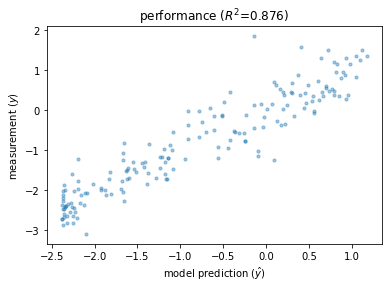

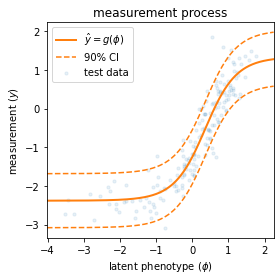

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.017 sec.
Epoch 1/1000
9/9 [==============================] - 0s 21ms/step - loss: 219.4020 - I_var: -0.1265 - val_loss: 184.4396 - val_I_var: -0.1351
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 165.6105 - I_var: 0.0193 - val_loss: 136.0084 - val_I_var: 0.0446
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 126.5032 - I_var: 0.2275 - val_loss: 104.9742 - val_I_var: 0.2957
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 100.1374 - I_var: 0.4380 - val_loss: 85.4810 - val_I_var: 0.4972
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 83.7078 - I_var: 0.5688 - val_loss: 73.7567 - val_I_var: 0.6275
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 73.2244 - I_var: 0.6543 - val_loss: 65.5749 - val_I_var: 0.7196
Epoch 7/1000
9/9 [==============================] - 0s 6ms/

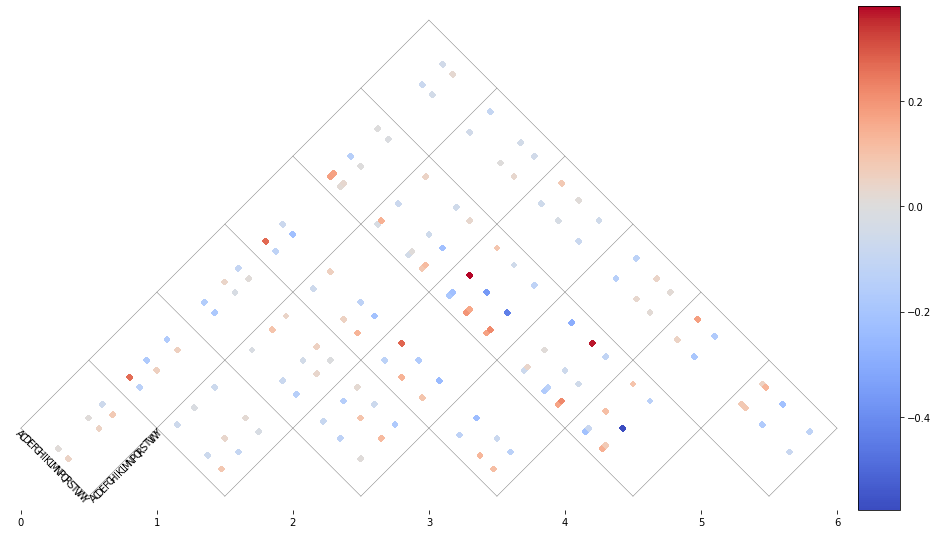

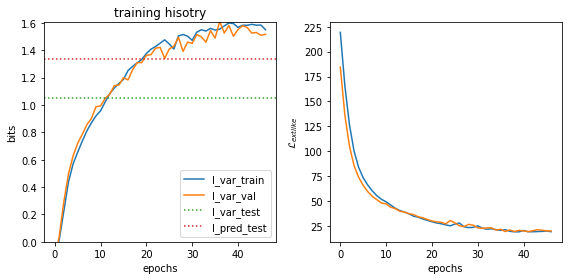

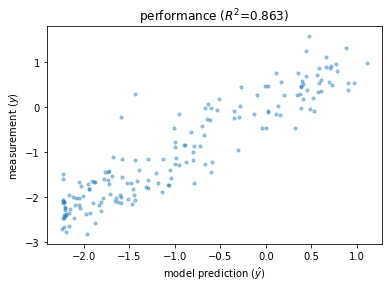

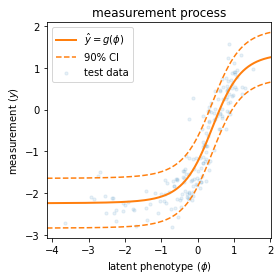

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0166 sec.
Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 219.4234 - I_var: -0.2225 - val_loss: 181.3963 - val_I_var: -0.0835
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 165.2669 - I_var: -0.0817 - val_loss: 139.1515 - val_I_var: 0.0317
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 126.7374 - I_var: 0.1472 - val_loss: 107.3556 - val_I_var: 0.2453
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 101.1689 - I_var: 0.3404 - val_loss: 88.4937 - val_I_var: 0.4319
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 84.9268 - I_var: 0.4804 - val_loss: 77.0294 - val_I_var: 0.5381
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 74.2818 - I_var: 0.5756 - val_loss: 69.3927 - val_I_var: 0.6127
Epoch 7/1000
9/9 [==============================] - 0s 6m

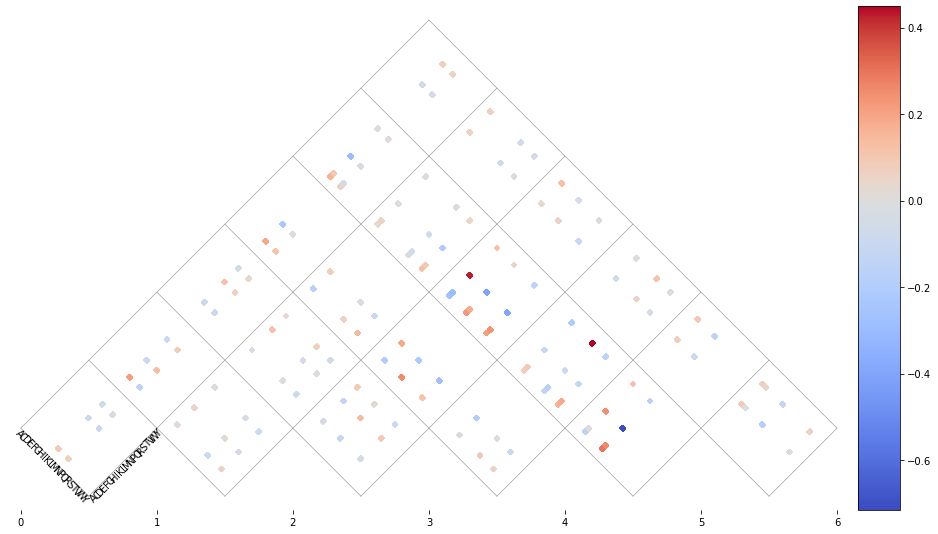

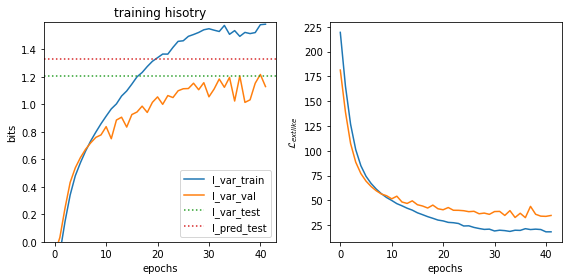

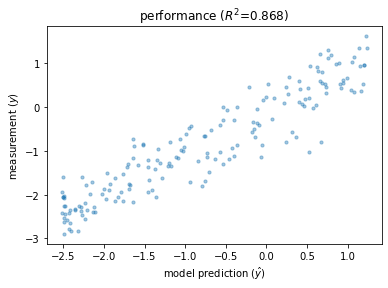

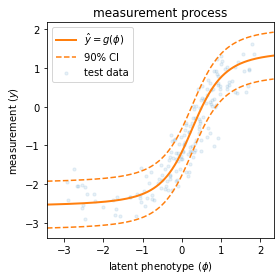

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0155 sec.
Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 202.1564 - I_var: -0.1997 - val_loss: 146.9533 - val_I_var: -0.2415
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 127.2452 - I_var: 0.0331 - val_loss: 100.1265 - val_I_var: 0.1924
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 89.4667 - I_var: 0.3671 - val_loss: 75.9104 - val_I_var: 0.4927
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 72.6896 - I_var: 0.5615 - val_loss: 66.5508 - val_I_var: 0.5921
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 62.7436 - I_var: 0.6992 - val_loss: 58.8219 - val_I_var: 0.7715
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 54.3370 - I_var: 0.8538 - val_loss: 53.2381 - val_I_var: 0.8632
Epoch 7/1000
9/9 [==============================] - 0s 6ms/st

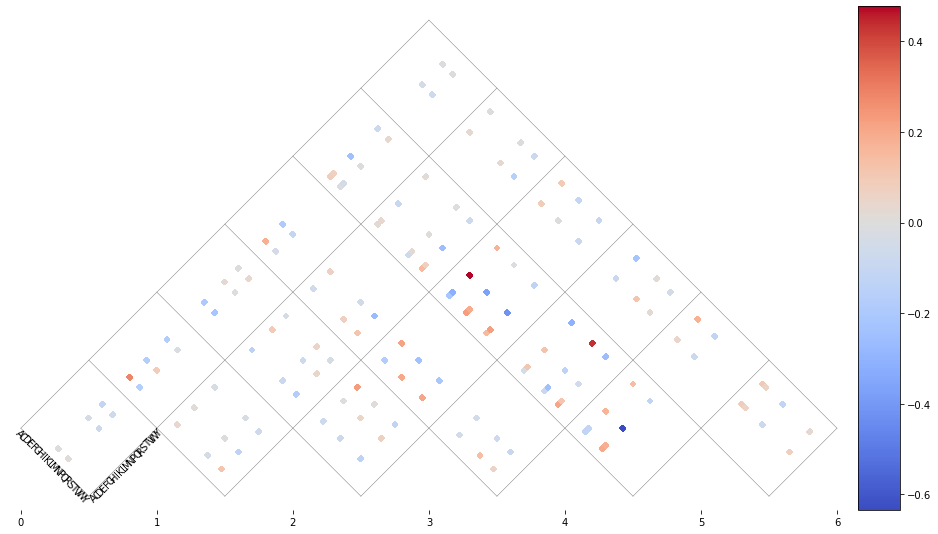

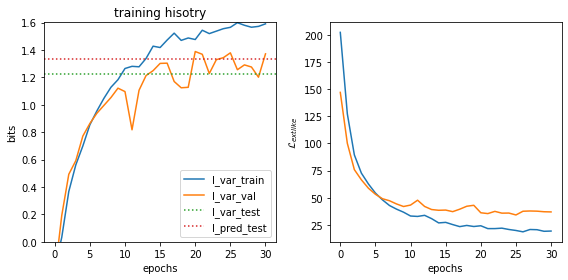

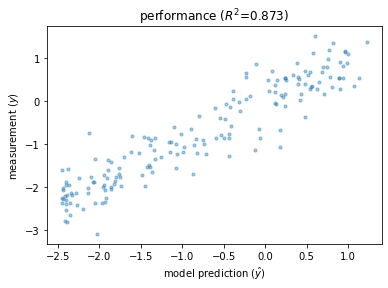

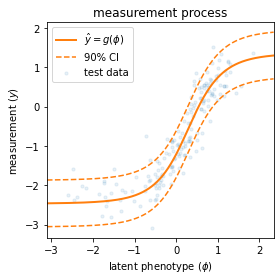

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0157 sec.
Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 204.0849 - I_var: -0.2160 - val_loss: 148.4464 - val_I_var: -0.0992
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 131.7995 - I_var: -0.0888 - val_loss: 103.5433 - val_I_var: 0.0791
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 94.1916 - I_var: 0.2147 - val_loss: 77.9366 - val_I_var: 0.3951
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 73.1658 - I_var: 0.5028 - val_loss: 65.8473 - val_I_var: 0.5869
Epoch 5/1000
9/9 [==============================] - 0s 7ms/step - loss: 63.2130 - I_var: 0.6378 - val_loss: 56.7354 - val_I_var: 0.6982
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 55.5162 - I_var: 0.7821 - val_loss: 50.8054 - val_I_var: 0.7982
Epoch 7/1000
9/9 [==============================] - 0s 7ms/s

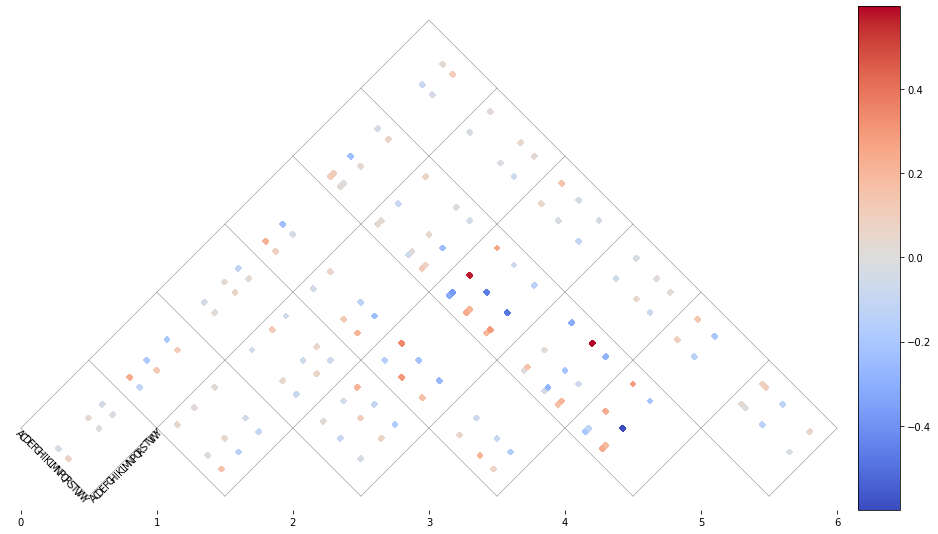

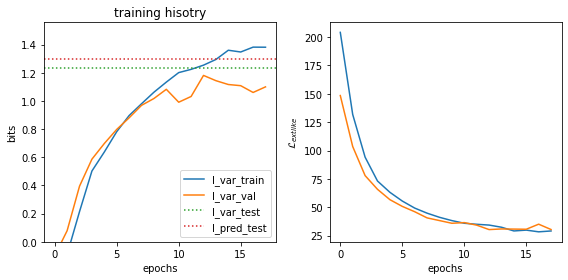

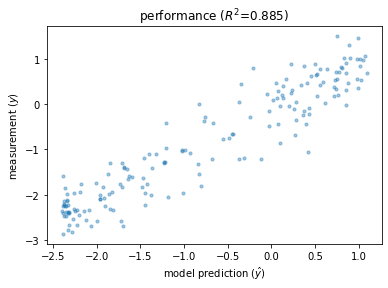

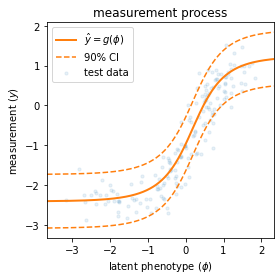

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.017 sec.
Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 156.9214 - I_var: -0.0944 - val_loss: 90.3983 - val_I_var: 0.1793
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 84.1978 - I_var: 0.4042 - val_loss: 66.8453 - val_I_var: 0.6132
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 64.9051 - I_var: 0.6920 - val_loss: 50.1200 - val_I_var: 0.8808
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 49.7176 - I_var: 0.9348 - val_loss: 40.5542 - val_I_var: 1.1678
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 44.2560 - I_var: 1.0313 - val_loss: 46.4581 - val_I_var: 1.0361
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 41.8060 - I_var: 1.1231 - val_loss: 35.0314 - val_I_var: 1.2965
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - 

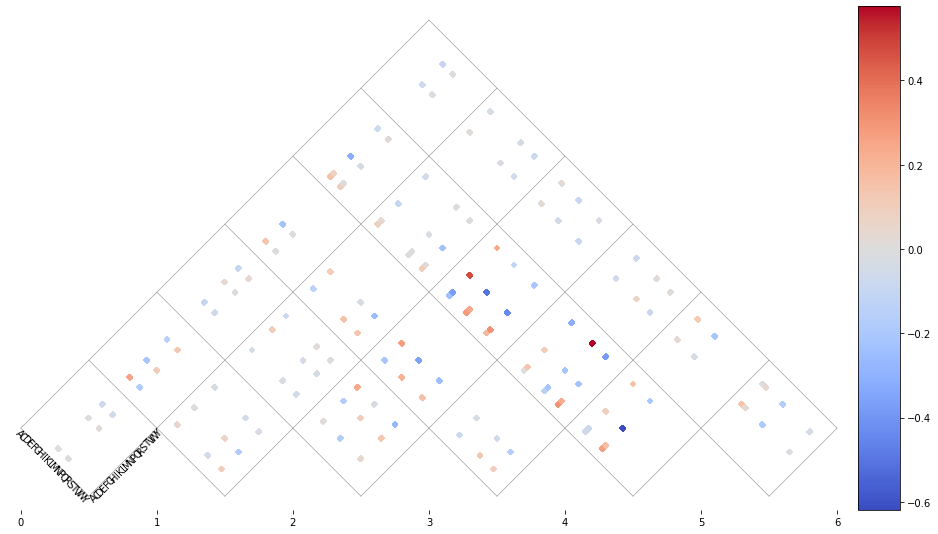

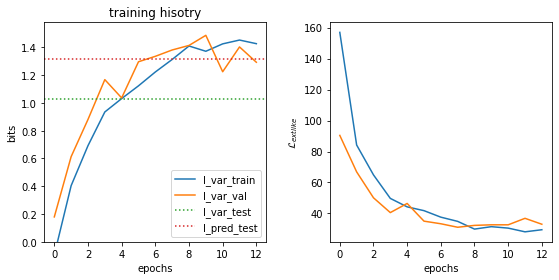

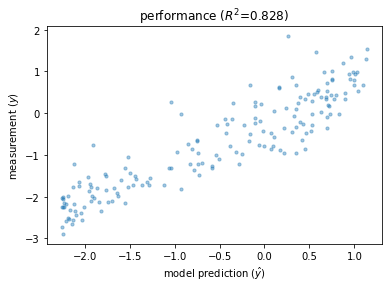

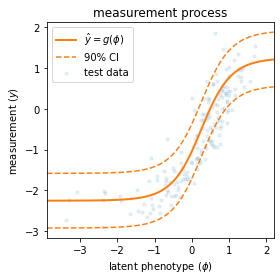

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0166 sec.
Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 146.5574 - I_var: 0.0183 - val_loss: 84.1744 - val_I_var: 0.3375
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 79.1004 - I_var: 0.4594 - val_loss: 63.1873 - val_I_var: 0.7381
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 58.2164 - I_var: 0.7629 - val_loss: 45.0442 - val_I_var: 0.9768
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 44.3517 - I_var: 0.9877 - val_loss: 35.8554 - val_I_var: 1.2071
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 38.3205 - I_var: 1.1453 - val_loss: 31.7731 - val_I_var: 1.1704
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 39.1737 - I_var: 1.1255 - val_loss: 36.0895 - val_I_var: 1.1388
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - 

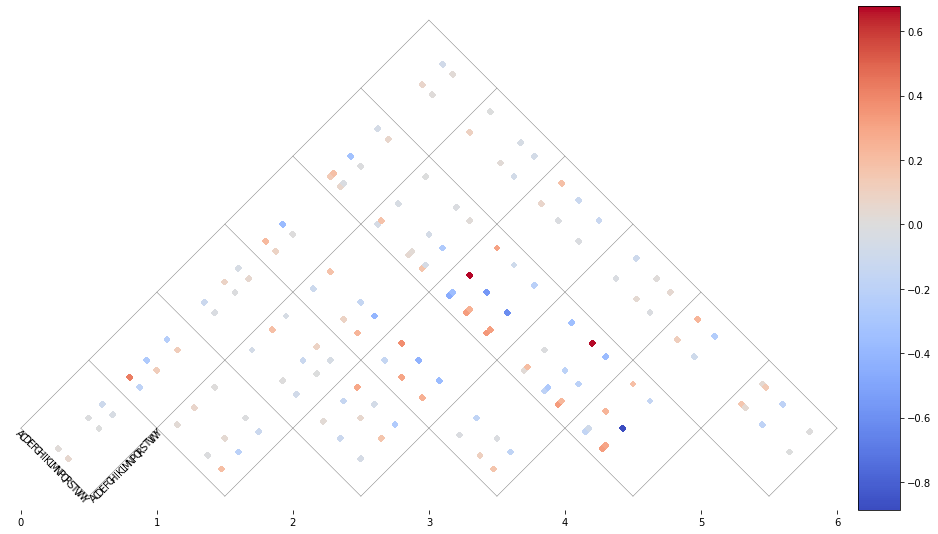

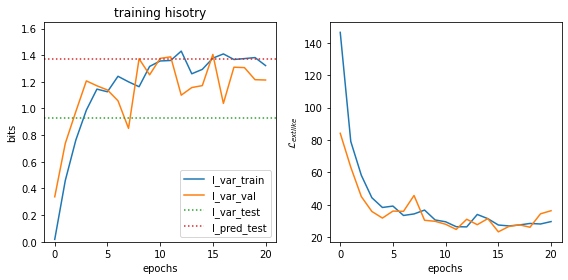

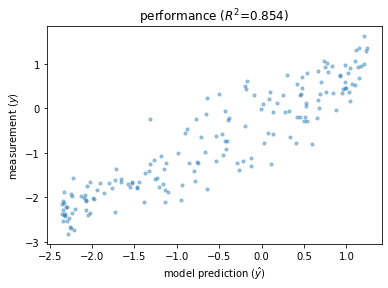

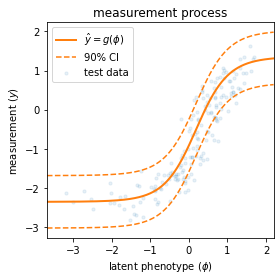

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0166 sec.
Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 141.6338 - I_var: -0.0694 - val_loss: 89.7640 - val_I_var: 0.3640
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 79.8625 - I_var: 0.5166 - val_loss: 64.9577 - val_I_var: 0.6078
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 57.5006 - I_var: 0.8381 - val_loss: 47.4273 - val_I_var: 0.9425
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 53.2217 - I_var: 0.8760 - val_loss: 59.0569 - val_I_var: 0.8552
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 53.5890 - I_var: 0.8542 - val_loss: 50.0448 - val_I_var: 0.9835
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 46.7364 - I_var: 1.0044 - val_loss: 47.0327 - val_I_var: 0.9299
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step -

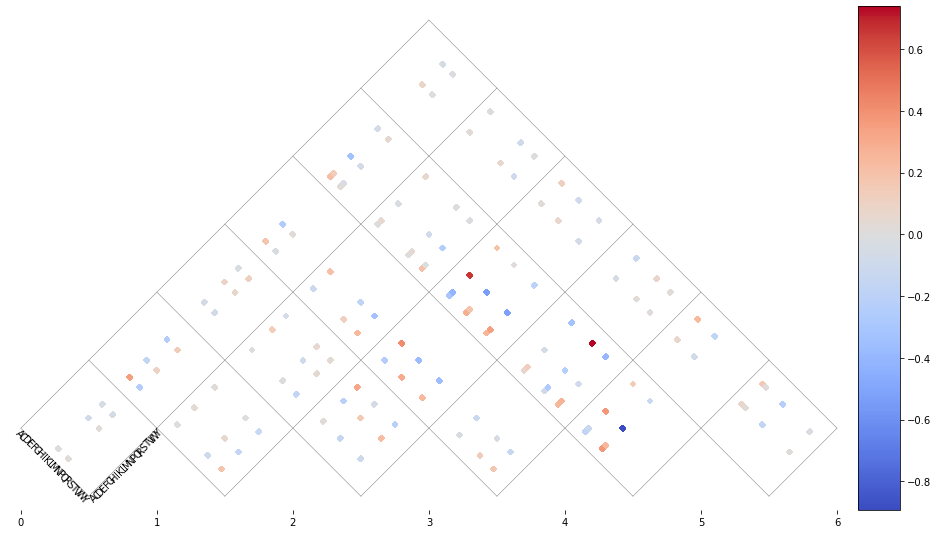

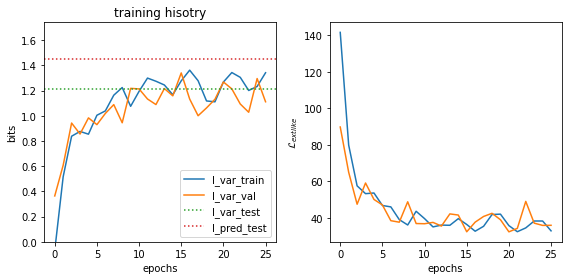

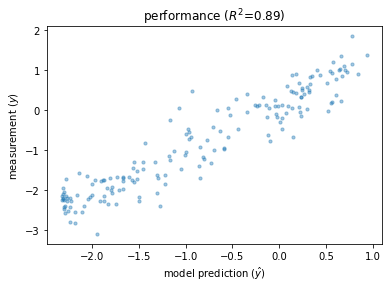

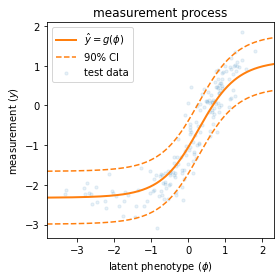

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0198 sec.
Epoch 1/1000
9/9 [==============================] - 0s 26ms/step - loss: 140.1282 - I_var: -0.0679 - val_loss: 94.9228 - val_I_var: 0.1151
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 79.6724 - I_var: 0.5562 - val_loss: 61.6669 - val_I_var: 0.5575
Epoch 3/1000
9/9 [==============================] - 0s 7ms/step - loss: 55.9346 - I_var: 0.8956 - val_loss: 50.5048 - val_I_var: 0.6303
Epoch 4/1000
9/9 [==============================] - 0s 7ms/step - loss: 49.4602 - I_var: 1.0026 - val_loss: 43.0918 - val_I_var: 0.8154
Epoch 5/1000
9/9 [==============================] - 0s 7ms/step - loss: 41.8913 - I_var: 1.1643 - val_loss: 45.8923 - val_I_var: 1.0395
Epoch 6/1000
9/9 [==============================] - 0s 7ms/step - loss: 39.7989 - I_var: 1.1736 - val_loss: 37.4713 - val_I_var: 0.9345
Epoch 7/1000
9/9 [==============================] - 0s 7ms/step -

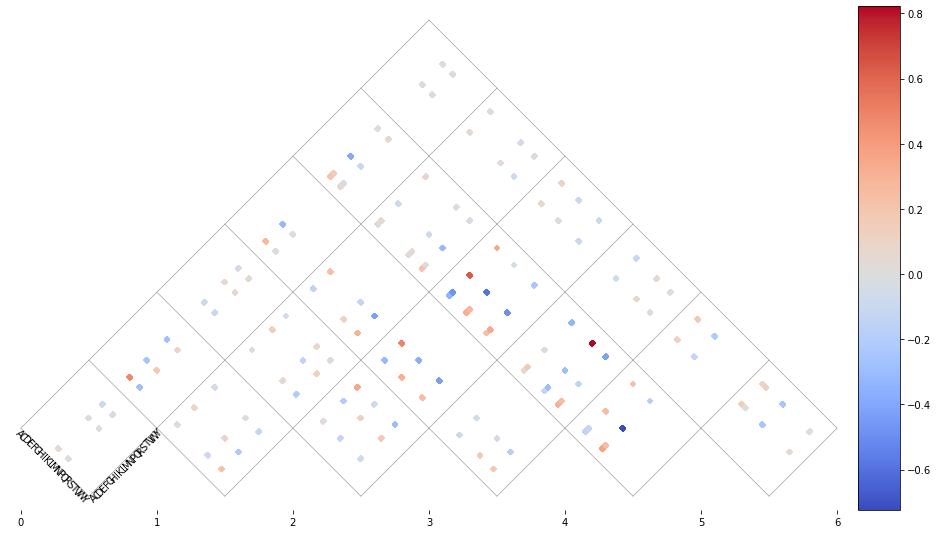

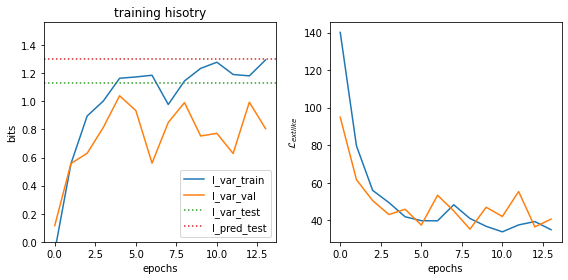

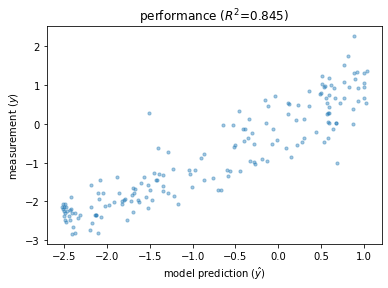

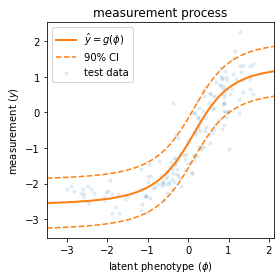

[[-0.23190787]
 [ 0.41615949]
 [ 0.44019809]
 [ 0.88611478]
 [ 0.94865295]]
[[0.84010845]
 [0.89723496]
 [0.93539332]
 [0.96588862]
 [0.9577086 ]]


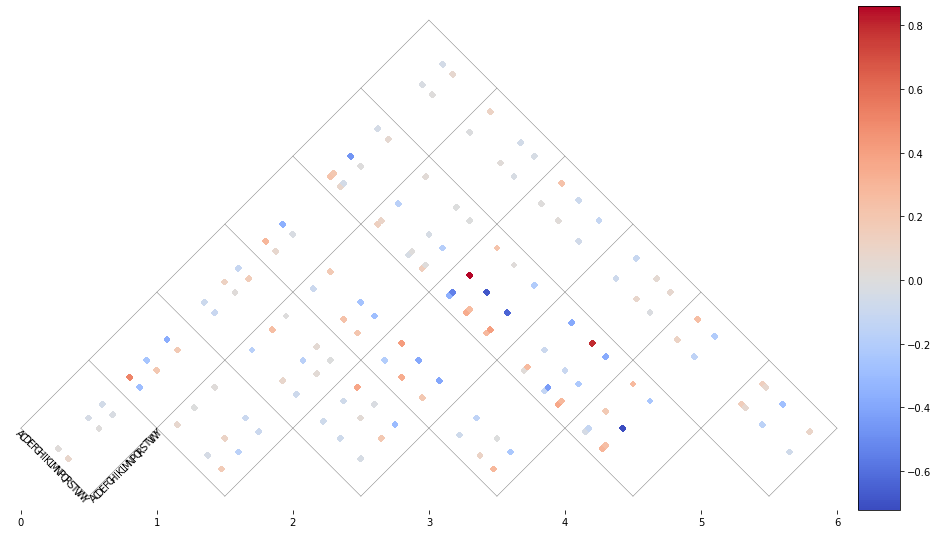

In [21]:
#Find the best regularization for additive fitness(learning rate)
lr_ls=[1e-3,5e-3,1e-2,3e-2,5e-2]
add=np.zeros((5,1))
epi=np.zeros((5,1))
R2=np.zeros((19,2))
R2_epi=np.zeros((153,2))
for lr in lr_ls:
    for rep in [0,1]:
        train_set, test_set = LoadData('../result/NA_compile_results.tsv','Bei89') 
        model = Train_model(train_set,test_set,0.8,lr,64)
        PlotTrain(model,test_set)
        PlotR2(model,test_set)
        PlotGEnonlinearity(model,test_set)
        theta = model.get_theta()
        fig, ax = plt.subplots(1, 1, figsize=[16, 10])          
        mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
        theta_lc=theta['theta_lc']
        data = theta['theta_lclc']
        epi_map=array2df(data)
        epi_map=epi_map.dropna(thresh=3)
        epi_df = df2epimap(epi_map)
        
        add_df=reformat(theta_lc)
        R2[:,rep]=add_df['add_fit']
        R2_epi[:,rep]=epi_df['EPI']
    R = np.corrcoef(R2[:,0], R2[:,1])[0, 1]
    R_epi = np.corrcoef(R2_epi[:,0], R2_epi[:,1])[0, 1]
    index = lr_ls.index(lr)
    add[index,0]=R
    epi[index,0]=R_epi
print(add)   
print(epi)

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0193 sec.
Epoch 1/1000
35/35 [==============================] - 1s 22ms/step - loss: 39.0845 - I_var: 0.1999 - val_loss: 19.6243 - val_I_var: 0.5003
Epoch 2/1000
35/35 [==============================] - 0s 4ms/step - loss: 20.9073 - I_var: 0.3319 - val_loss: 19.6084 - val_I_var: 0.4220
Epoch 3/1000
35/35 [==============================] - 0s 3ms/step - loss: 18.4651 - I_var: 0.4583 - val_loss: 16.2705 - val_I_var: 0.7203
Epoch 4/1000
35/35 [==============================] - 0s 4ms/step - loss: 18.8110 - I_var: 0.4962 - val_loss: 19.1620 - val_I_var: 0.4404
Epoch 5/1000
35/35 [==============================] - 0s 4ms/step - loss: 17.9301 - I_var: 0.5377 - val_loss: 19.1361 - val_I_var: 0.4502
Epoch 6/1000
35/35 [==============================] - 0s 4ms/step - loss: 17.8244 - I_var: 0.5671 - val_loss: 19.5404 - val_I_var: 0.4421
Epoch 7/1000
35/35 [==============================] - 0

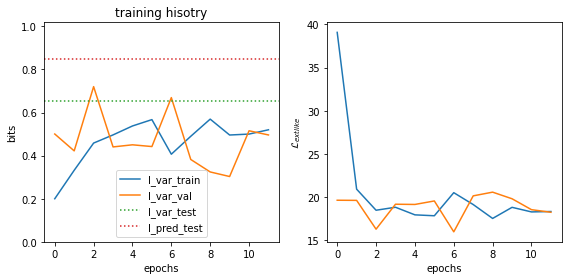

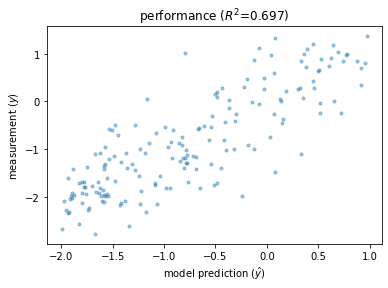

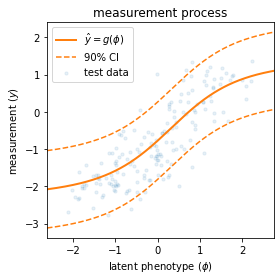

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.021 sec.
Epoch 1/1000
35/35 [==============================] - 0s 10ms/step - loss: 40.0969 - I_var: 0.0230 - val_loss: 24.9890 - val_I_var: -0.0190
Epoch 2/1000
35/35 [==============================] - 0s 4ms/step - loss: 18.2431 - I_var: 0.5563 - val_loss: 18.3927 - val_I_var: 0.5734
Epoch 3/1000
35/35 [==============================] - 0s 3ms/step - loss: 18.6206 - I_var: 0.5016 - val_loss: 19.0126 - val_I_var: 0.4682
Epoch 4/1000
35/35 [==============================] - 0s 4ms/step - loss: 19.0098 - I_var: 0.4338 - val_loss: 17.8181 - val_I_var: 0.5758
Epoch 5/1000
35/35 [==============================] - 0s 3ms/step - loss: 17.6864 - I_var: 0.5517 - val_loss: 20.9792 - val_I_var: 0.3160
Epoch 6/1000
35/35 [==============================] - 0s 3ms/step - loss: 18.3482 - I_var: 0.5092 - val_loss: 17.2586 - val_I_var: 0.6291
Epoch 7/1000
35/35 [==============================] - 0

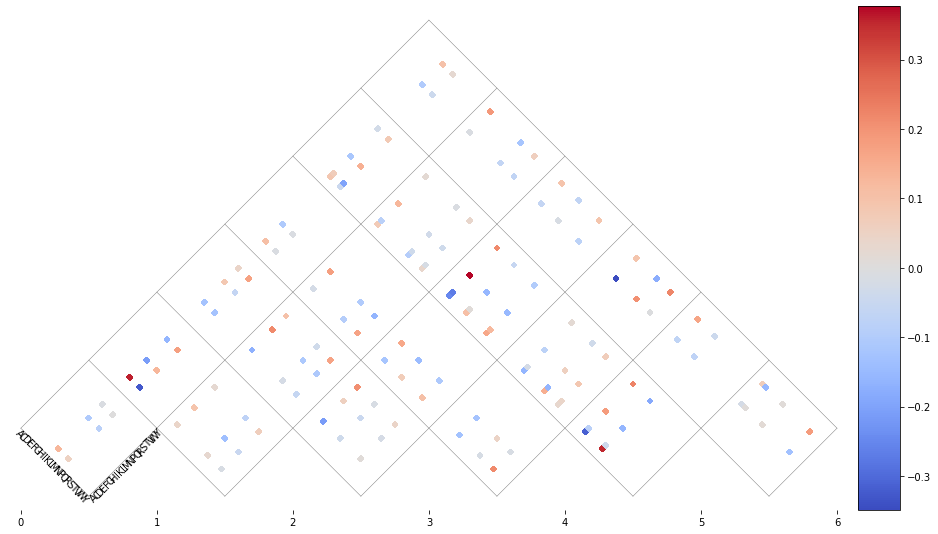

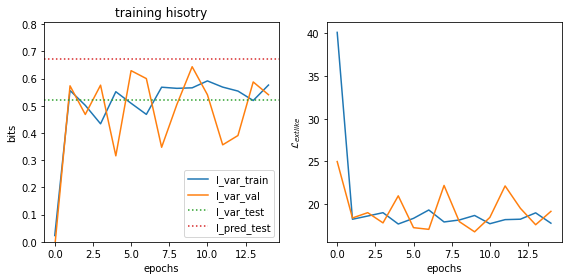

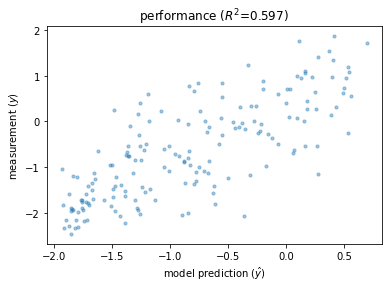

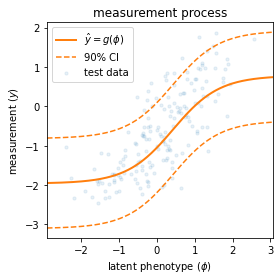

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0185 sec.
Epoch 1/1000
18/18 [==============================] - 0s 13ms/step - loss: 77.4282 - I_var: -0.0980 - val_loss: 39.1023 - val_I_var: 0.4297
Epoch 2/1000
18/18 [==============================] - 0s 4ms/step - loss: 37.9712 - I_var: 0.4230 - val_loss: 32.5569 - val_I_var: 0.4428
Epoch 3/1000
18/18 [==============================] - 0s 4ms/step - loss: 32.1777 - I_var: 0.6447 - val_loss: 25.1411 - val_I_var: 0.8620
Epoch 4/1000
18/18 [==============================] - 0s 4ms/step - loss: 27.8437 - I_var: 0.8395 - val_loss: 29.7007 - val_I_var: 0.4870
Epoch 5/1000
18/18 [==============================] - 0s 4ms/step - loss: 30.2067 - I_var: 0.7419 - val_loss: 28.3797 - val_I_var: 0.7334
Epoch 6/1000
18/18 [==============================] - 0s 4ms/step - loss: 30.0791 - I_var: 0.7261 - val_loss: 36.7239 - val_I_var: 0.2548
Epoch 7/1000
18/18 [==============================] - 

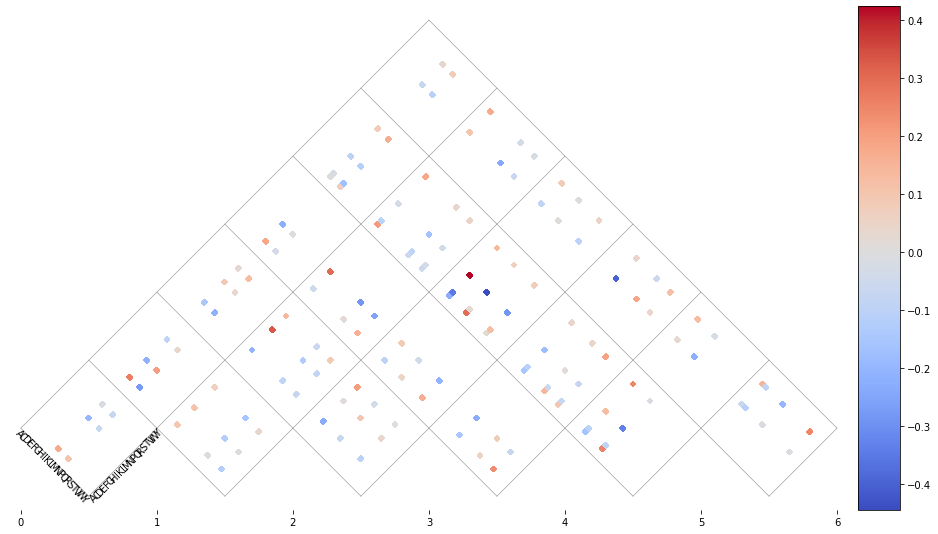

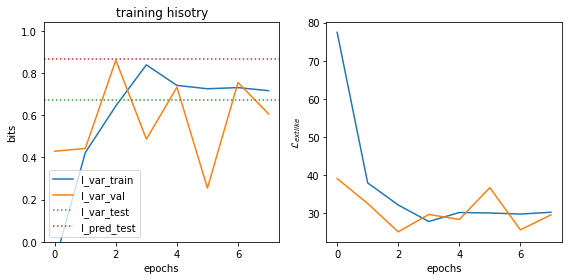

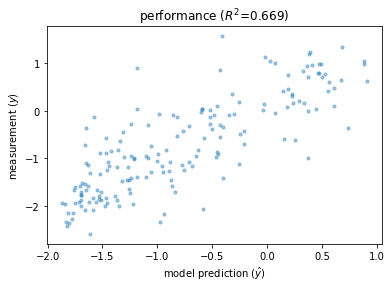

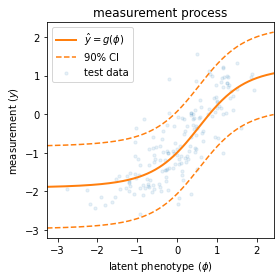

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0198 sec.
Epoch 1/1000
18/18 [==============================] - 0s 12ms/step - loss: 71.5813 - I_var: 0.2457 - val_loss: 37.3660 - val_I_var: 0.5200
Epoch 2/1000
18/18 [==============================] - 0s 4ms/step - loss: 38.8823 - I_var: 0.5052 - val_loss: 32.8751 - val_I_var: 0.6784
Epoch 3/1000
18/18 [==============================] - 0s 4ms/step - loss: 34.0919 - I_var: 0.6358 - val_loss: 27.2732 - val_I_var: 0.7620
Epoch 4/1000
18/18 [==============================] - 0s 5ms/step - loss: 30.8318 - I_var: 0.6787 - val_loss: 28.7475 - val_I_var: 0.6552
Epoch 5/1000
18/18 [==============================] - 0s 5ms/step - loss: 32.4504 - I_var: 0.6082 - val_loss: 28.3173 - val_I_var: 0.7894
Epoch 6/1000
18/18 [==============================] - 0s 4ms/step - loss: 30.0437 - I_var: 0.7242 - val_loss: 27.2620 - val_I_var: 0.7751
Epoch 7/1000
18/18 [==============================] - 0

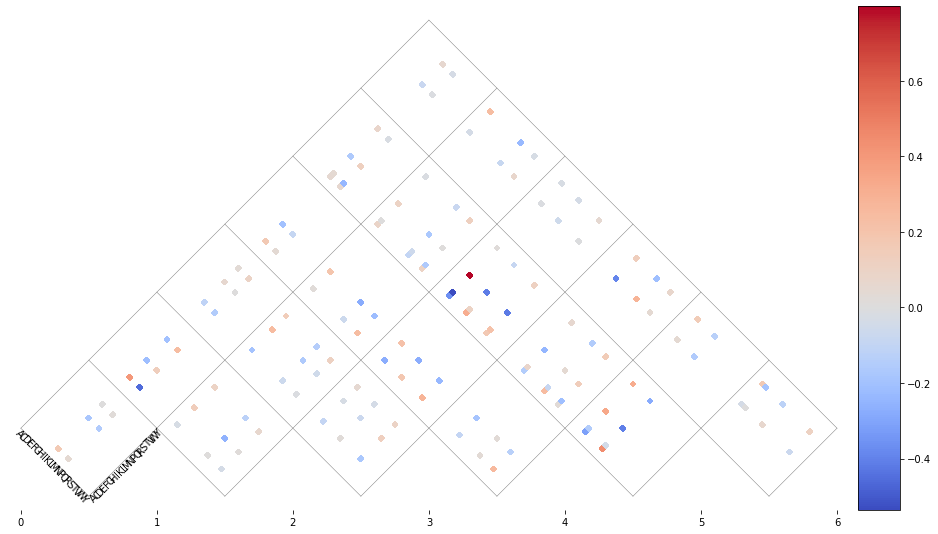

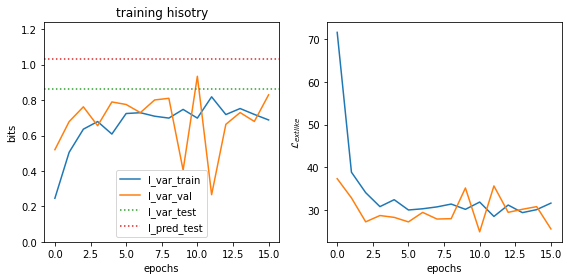

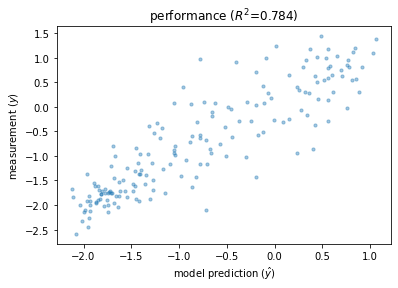

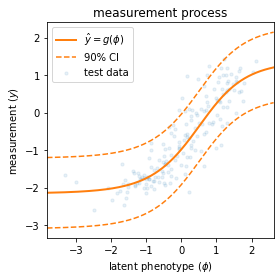

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0194 sec.
Epoch 1/1000
12/12 [==============================] - 0s 18ms/step - loss: 109.6037 - I_var: -0.0298 - val_loss: 72.9364 - val_I_var: 0.2131
Epoch 2/1000
12/12 [==============================] - 0s 5ms/step - loss: 57.2701 - I_var: 0.5035 - val_loss: 69.9697 - val_I_var: -0.1085
Epoch 3/1000
12/12 [==============================] - 0s 5ms/step - loss: 52.5447 - I_var: 0.4654 - val_loss: 47.7772 - val_I_var: 0.6069
Epoch 4/1000
12/12 [==============================] - 0s 5ms/step - loss: 46.2171 - I_var: 0.6650 - val_loss: 44.9627 - val_I_var: 0.6562
Epoch 5/1000
12/12 [==============================] - 0s 5ms/step - loss: 38.7385 - I_var: 0.8563 - val_loss: 40.0243 - val_I_var: 0.7654
Epoch 6/1000
12/12 [==============================] - 0s 5ms/step - loss: 36.8691 - I_var: 0.8578 - val_loss: 49.0715 - val_I_var: 0.4845
Epoch 7/1000
12/12 [==============================] 

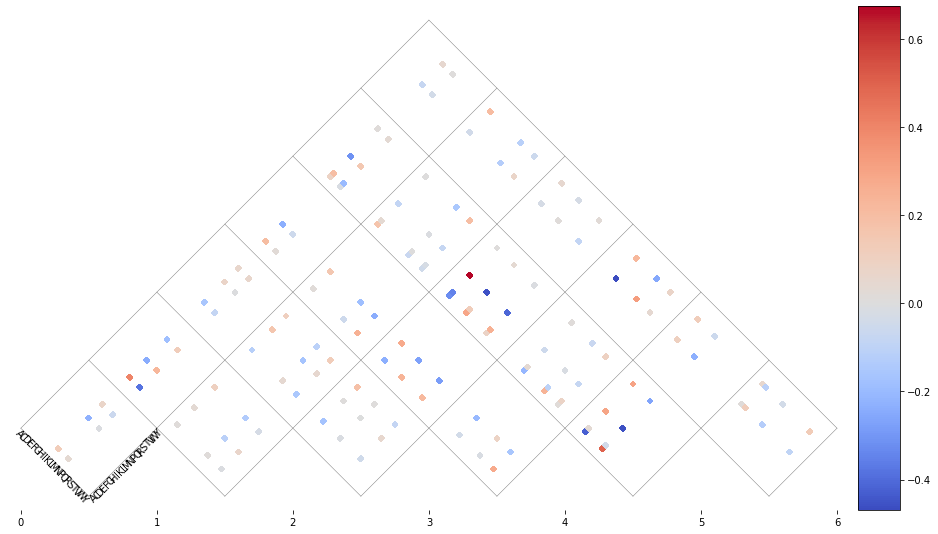

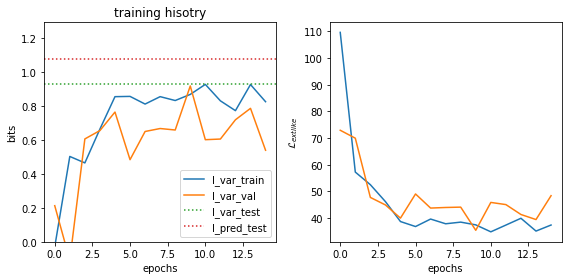

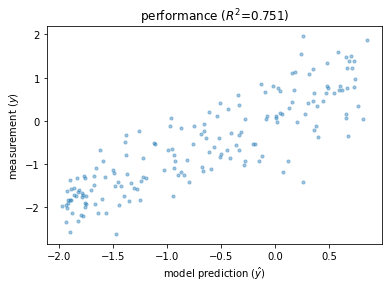

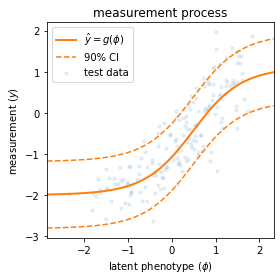

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0193 sec.
Epoch 1/1000
12/12 [==============================] - 0s 19ms/step - loss: 113.2593 - I_var: -0.1957 - val_loss: 79.5298 - val_I_var: -0.0838
Epoch 2/1000
12/12 [==============================] - 0s 6ms/step - loss: 62.0384 - I_var: 0.3386 - val_loss: 51.7157 - val_I_var: 0.5199
Epoch 3/1000
12/12 [==============================] - 0s 6ms/step - loss: 50.7146 - I_var: 0.5450 - val_loss: 52.6443 - val_I_var: 0.4647
Epoch 4/1000
12/12 [==============================] - 0s 5ms/step - loss: 51.3632 - I_var: 0.5354 - val_loss: 51.7333 - val_I_var: 0.4884
Epoch 5/1000
12/12 [==============================] - 0s 5ms/step - loss: 48.0041 - I_var: 0.6255 - val_loss: 45.8108 - val_I_var: 0.6573
Epoch 6/1000
12/12 [==============================] - 0s 6ms/step - loss: 44.6554 - I_var: 0.6709 - val_loss: 43.0950 - val_I_var: 0.7045
Epoch 7/1000
12/12 [==============================] 

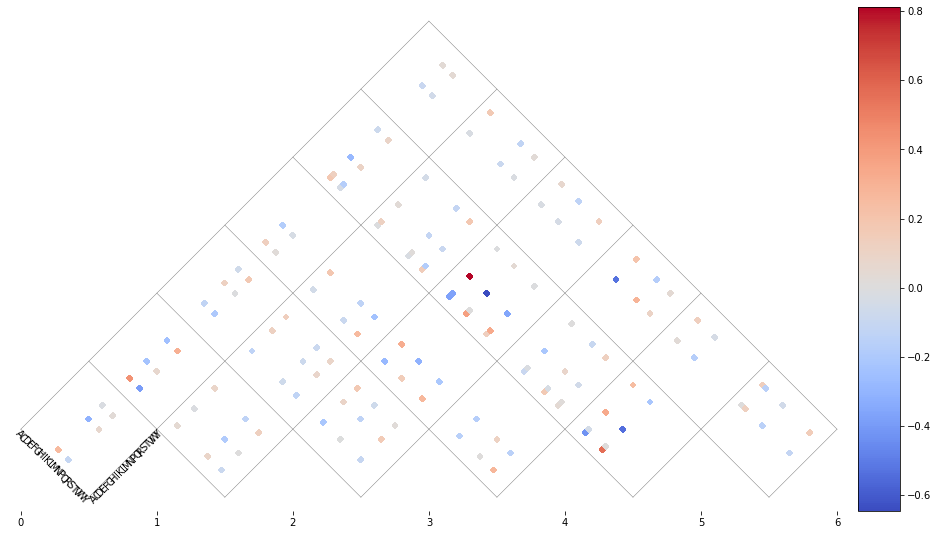

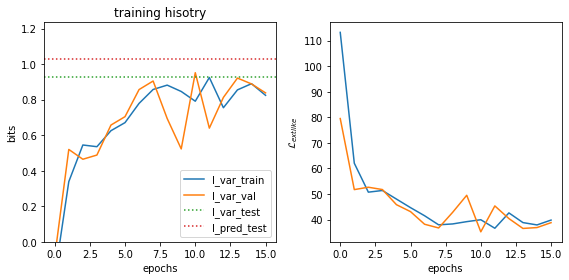

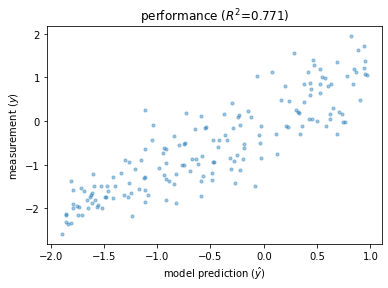

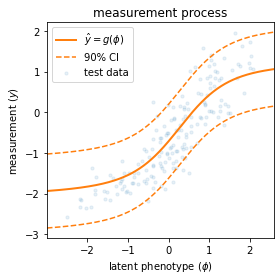

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0195 sec.
Epoch 1/1000
9/9 [==============================] - 0s 22ms/step - loss: 145.8879 - I_var: -0.2364 - val_loss: 96.8763 - val_I_var: 0.1099
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 86.4447 - I_var: 0.2639 - val_loss: 63.6709 - val_I_var: 0.5209
Epoch 3/1000
9/9 [==============================] - 0s 7ms/step - loss: 62.3261 - I_var: 0.6090 - val_loss: 56.0144 - val_I_var: 0.6522
Epoch 4/1000
9/9 [==============================] - 0s 7ms/step - loss: 57.2275 - I_var: 0.6959 - val_loss: 51.8050 - val_I_var: 0.7713
Epoch 5/1000
9/9 [==============================] - 0s 7ms/step - loss: 54.8509 - I_var: 0.7706 - val_loss: 46.8411 - val_I_var: 0.8886
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 48.3904 - I_var: 0.9142 - val_loss: 63.7592 - val_I_var: 0.5023
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step -

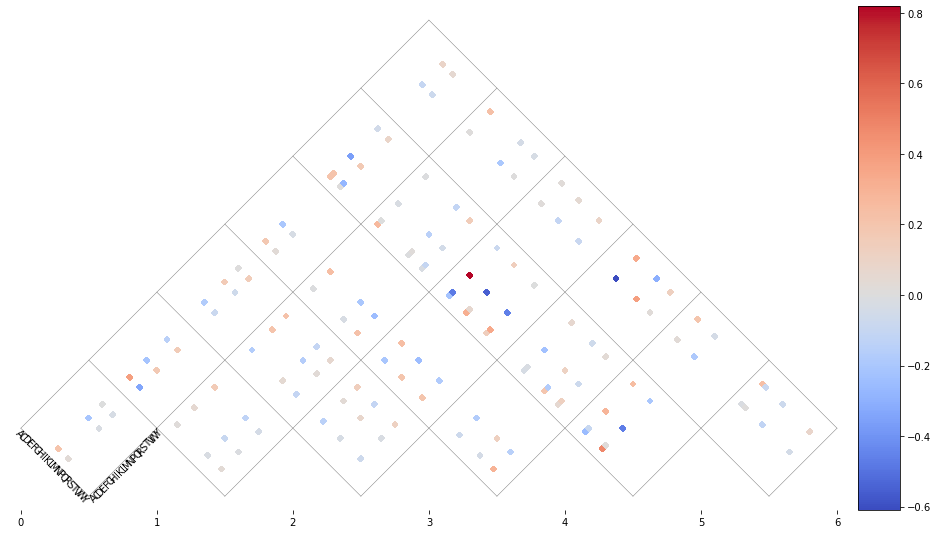

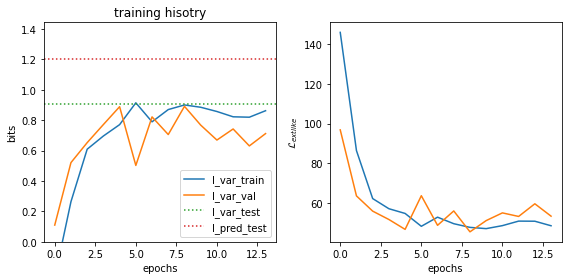

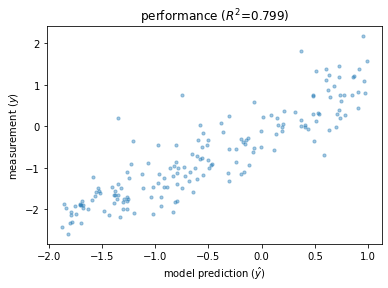

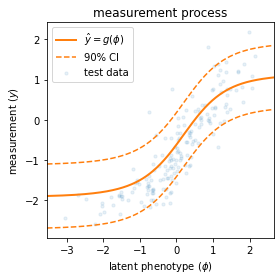

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.018 sec.
Epoch 1/1000
9/9 [==============================] - 0s 24ms/step - loss: 145.6995 - I_var: -0.1722 - val_loss: 106.3355 - val_I_var: -0.2252
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 104.0147 - I_var: -0.0835 - val_loss: 88.4827 - val_I_var: -0.1359
Epoch 3/1000
9/9 [==============================] - 0s 7ms/step - loss: 80.9227 - I_var: 0.2405 - val_loss: 65.3027 - val_I_var: 0.3813
Epoch 4/1000
9/9 [==============================] - 0s 7ms/step - loss: 67.2738 - I_var: 0.5347 - val_loss: 52.5778 - val_I_var: 0.6760
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 54.2507 - I_var: 0.8429 - val_loss: 50.5821 - val_I_var: 0.7996
Epoch 6/1000
9/9 [==============================] - 0s 7ms/step - loss: 54.1221 - I_var: 0.8341 - val_loss: 61.3822 - val_I_var: 0.5087
Epoch 7/1000
9/9 [==============================] - 0s 7ms/st

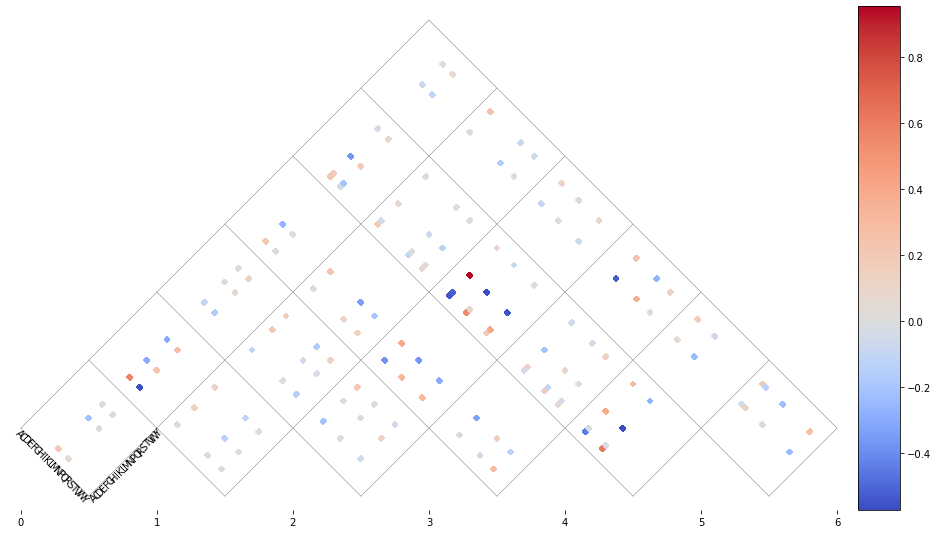

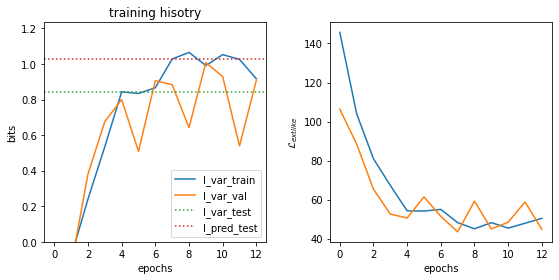

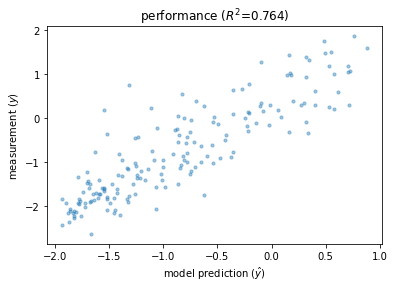

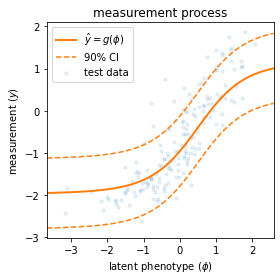

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0192 sec.
Epoch 1/1000
5/5 [==============================] - 0s 41ms/step - loss: 262.1097 - I_var: -0.2019 - val_loss: 184.6798 - val_I_var: -0.0724
Epoch 2/1000
5/5 [==============================] - 0s 11ms/step - loss: 176.2278 - I_var: 0.1035 - val_loss: 157.7098 - val_I_var: 0.1389
Epoch 3/1000
5/5 [==============================] - 0s 11ms/step - loss: 150.4309 - I_var: 0.3907 - val_loss: 136.4608 - val_I_var: 0.4533
Epoch 4/1000
5/5 [==============================] - 0s 12ms/step - loss: 126.5444 - I_var: 0.5645 - val_loss: 115.7416 - val_I_var: 0.6628
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 107.0345 - I_var: 0.7413 - val_loss: 100.8507 - val_I_var: 0.8122
Epoch 6/1000
5/5 [==============================] - 0s 12ms/step - loss: 93.7937 - I_var: 0.7921 - val_loss: 129.6173 - val_I_var: 0.7184
Epoch 7/1000
5/5 [==============================]

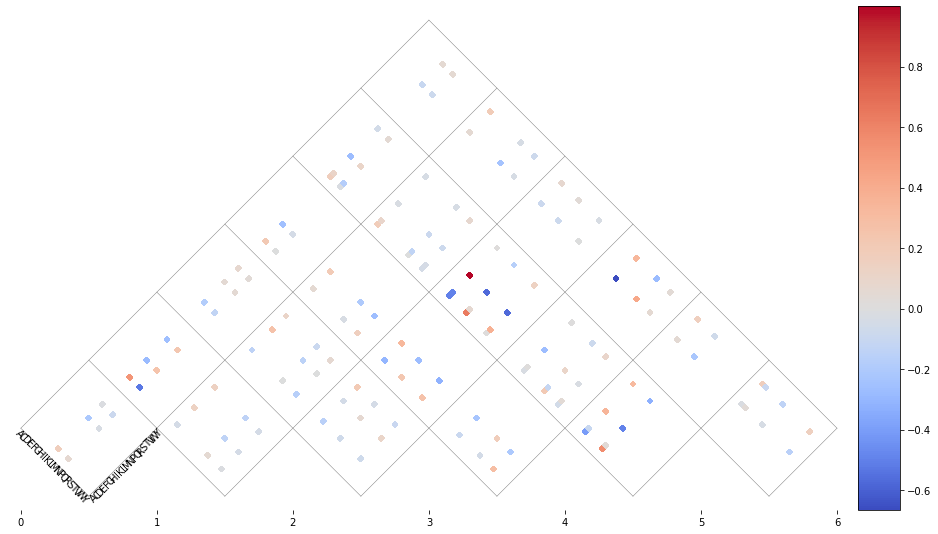

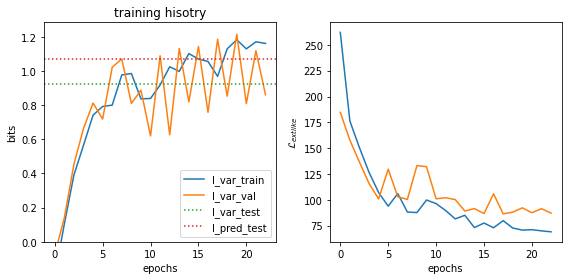

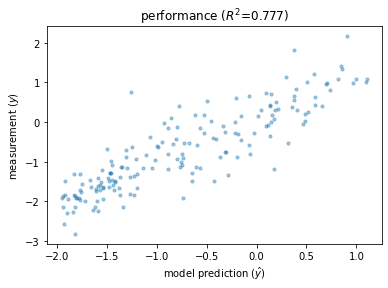

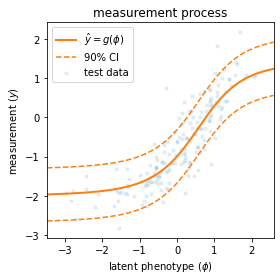

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0179 sec.
Epoch 1/1000
5/5 [==============================] - 0s 43ms/step - loss: 264.6872 - I_var: -0.2816 - val_loss: 171.4860 - val_I_var: -0.0267
Epoch 2/1000
5/5 [==============================] - 0s 11ms/step - loss: 169.5952 - I_var: 0.1626 - val_loss: 155.5720 - val_I_var: 0.1392
Epoch 3/1000
5/5 [==============================] - 0s 12ms/step - loss: 145.9982 - I_var: 0.3903 - val_loss: 128.2106 - val_I_var: 0.3144
Epoch 4/1000
5/5 [==============================] - 0s 12ms/step - loss: 114.7804 - I_var: 0.6833 - val_loss: 116.3233 - val_I_var: 0.2005
Epoch 5/1000
5/5 [==============================] - 0s 12ms/step - loss: 101.1405 - I_var: 0.8394 - val_loss: 92.0458 - val_I_var: 0.1136
Epoch 6/1000
5/5 [==============================] - 0s 11ms/step - loss: 86.8737 - I_var: 0.9250 - val_loss: 103.7931 - val_I_var: -0.2001
Epoch 7/1000
5/5 [==============================]

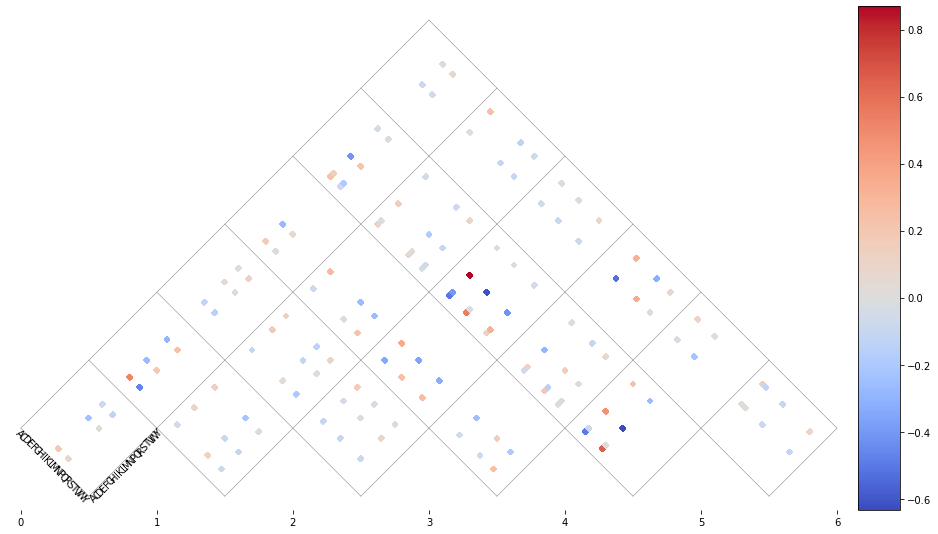

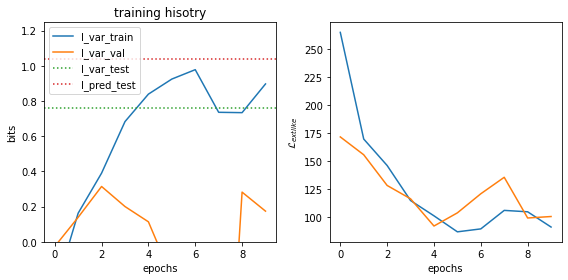

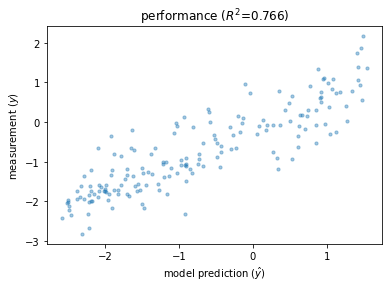

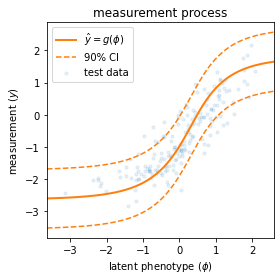

[[0.94314826]
 [0.94183202]
 [0.95996723]
 [0.92451872]
 [0.77867837]]
[[0.81531911]
 [0.90422056]
 [0.92308953]
 [0.96575298]
 [0.93304871]]


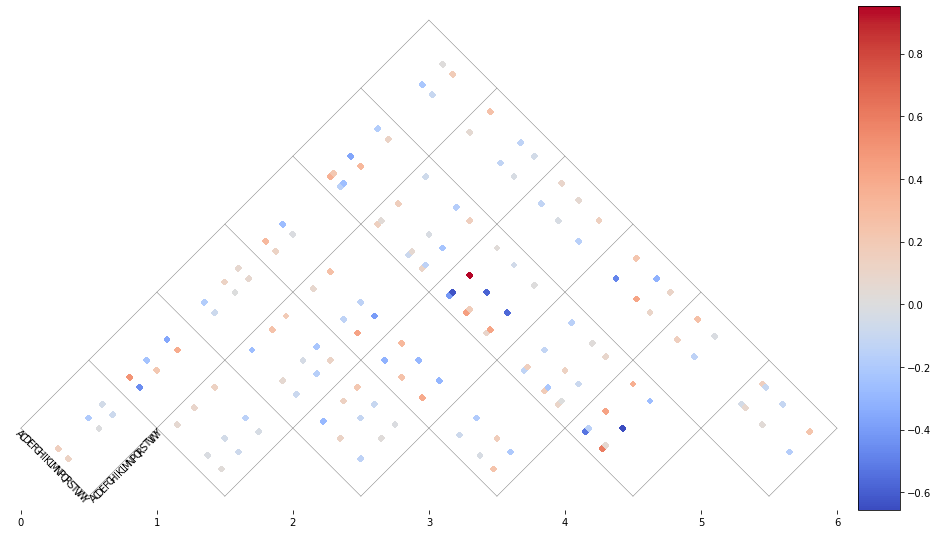

In [17]:
#Find the best regularization for additive fitness(batch_size)
bs_ls=[16,32,48,64,128]
add=np.zeros((5,1))
epi=np.zeros((5,1))
R2=np.zeros((19,2))
R2_epi=np.zeros((153,2))
for bs in bs_ls:
    for rep in [0,1]:
        train_set, test_set = LoadData('../result/NA_compile_results.tsv','HK19') 
        model = Train_model(train_set,test_set,0.8,0.05,bs)
        PlotTrain(model,test_set)
        PlotR2(model,test_set)
        PlotGEnonlinearity(model,test_set)
        theta = model.get_theta()
        fig, ax = plt.subplots(1, 1, figsize=[16, 10])          
        mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
        theta_lc=theta['theta_lc']
        data = theta['theta_lclc']
        epi_map=array2df(data)
        epi_map=epi_map.dropna(thresh=3)
        epi_df = df2epimap(epi_map)
        
        add_df=reformat(theta_lc)
        R2[:,rep]=add_df['add_fit']
        R2_epi[:,rep]=epi_df['EPI']
    R = np.corrcoef(R2[:,0], R2[:,1])[0, 1]
    R_epi = np.corrcoef(R2_epi[:,0], R2_epi[:,1])[0, 1]
    index = bs_ls.index(bs)
    add[index,0]=R
    epi[index,0]=R_epi
print(add)   
print(epi)

We now define a MAVE-NN model with pairwise G-P map and a Gaussian noise model. 

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


     index       ID strain        pI  charge  rep1_fit  rep2_fit       fit  \
0      707  NNESKKS   HK68  6.375305       1  0.018204  0.109588  0.063896   
1      188  NDRGKTS   HK68  6.374207       1  0.029351  0.048562  0.038956   
2      772  KNKGKTL   HK68  6.776550       3  0.019257  0.014317  0.016787   
3      710  KSRNKKL   HK68  7.067078       4  0.040903  0.086621  0.063762   
4      848  NSENEKS   HK68  6.087708      -1  0.069035  0.154373  0.111704   
..     ...      ...    ...       ...     ...       ...       ...       ...   
686     55  KDESKTL   HK68  6.222717       0  0.044427  0.063992  0.054209   
687    638  KSRSEKS   HK68  6.554993       2  0.023715  0.051238  0.037476   
688    662  KSKGEEL   HK68  6.224182       0  0.061383  0.067500  0.064441   
689    314  KSKNEDL   HK68  6.222717       0  0.024591  0.083983  0.054287   
690    723  NDEGETL   HK68  5.846130      -3  0.007152  0.025755  0.016453   

            y    set  
0   -2.750498  train  
1   -3.245311  tr

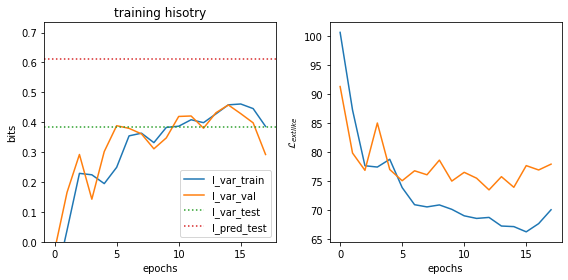

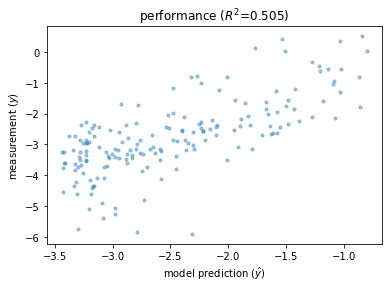

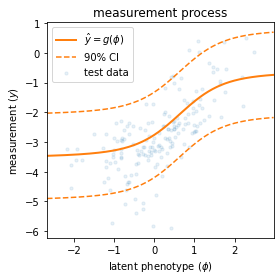

Model saved to these files:
	../result/HK68_epi.pickle
	../result/HK68_epi.h5
      L1   L2 AA1 AA2       EPI
0    1.0  2.0   K   D  0.081668
1    1.0  2.0   K   N -0.328533
2    1.0  2.0   K   S  0.009662
3    1.0  2.0   N   D  0.201639
4    1.0  2.0   N   N  0.054113
..   ...  ...  ..  ..       ...
148  6.0  7.0   E   S -0.151311
149  6.0  7.0   K   L -0.152512
150  6.0  7.0   K   S -0.103566
151  6.0  7.0   T   L -0.118993
152  6.0  7.0   T   S  0.101132

[153 rows x 5 columns]
    pos aa   add_fit
0   328  K -0.593514
1   328  N  0.350432
2   329  D  0.184039
3   329  N -0.153291
4   329  S -0.225173
5   344  E -0.184203
6   344  K -0.035719
7   344  R -0.177462
8   367  G -0.276893
9   367  N -0.049775
10  367  S  0.011694
11  368  E  0.145801
12  368  K -0.005980
13  369  D  0.121286
14  369  E  0.257100
15  369  K -0.283460
16  369  T  0.149919
17  370  L -0.250806
18  370  S -0.153319


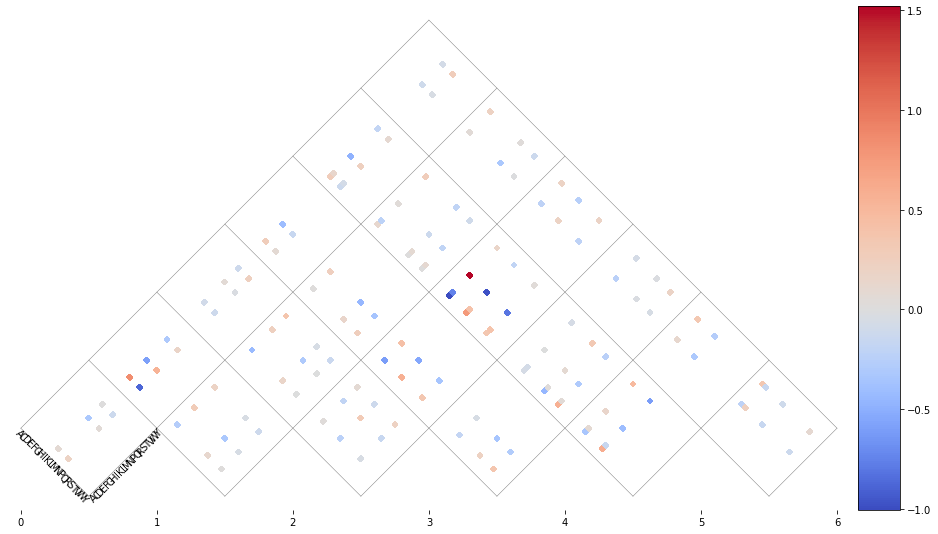

In [9]:
##Loading HK68 data, training and plotting
train_set, test_set = LoadData('../result/NA_compile_results.tsv','HK68')
print(train_set)
model = Train_model(train_set,test_set,0.1,0.05,64)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
model.save('../result/HK68_epi')
#model = mavenn.load('../result/HK68_epi')
## Plot additive 
## Plot epistasis
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10])          
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
#save epistasis and additive
data = theta['theta_lclc']
theta_lc=theta['theta_lc']
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/HK68_epi.csv')
print(epi_df)
add_df=reformat(theta_lc)
add_df.to_csv('../result/HK68_add.csv')
print(add_df)

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


     index       ID strain        pI  charge  rep1_fit  rep2_fit       fit  \
0     1229  KSENKKL   Bk79  7.728577       2  0.146677  0.145866  0.146271   
1     1022  KSKGKKL   Bk79  8.126282       4  0.186873  0.031092  0.108982   
2     1265  KSEGEES   Bk79  6.513977      -2  0.255496  0.180364  0.217930   
3     1702  KSKGEDS   Bk79  7.040100       0  0.152916  0.316736  0.234826   
4      986  KNRNKTL   Bk79  7.961609       3  0.028756  0.083173  0.055964   
..     ...      ...    ...       ...     ...       ...       ...       ...   
686   1212  NSEGKTL   Bk79  7.040100       0  0.071672  0.061159  0.066416   
687   1641  NSRGKTL   Bk79  7.731384       2  0.013310  0.122875  0.068093   
688   1634  KDKNEDL   Bk79  6.741272      -1  3.151628  3.976497  3.564062   
689    939  NSKSKES   Bk79  7.404846       1  0.080138  0.202591  0.141365   
690   1237  KSRNKES   Bk79  7.730042       2  0.010915  0.019264  0.015090   

            y    set  
0   -1.922291  train  
1   -2.216569  tr

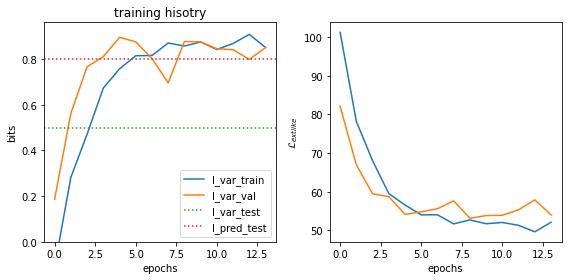

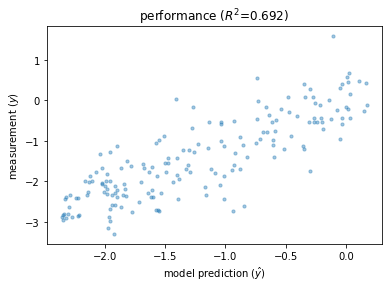

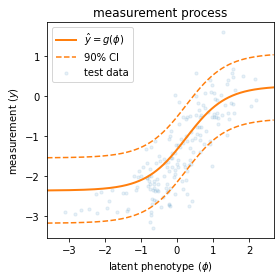

Model saved to these files:
	../result/Bk79_epi.pickle
	../result/Bk79_epi.h5
      L1   L2 AA1 AA2       EPI
0    1.0  2.0   K   D  0.248821
1    1.0  2.0   K   N -0.320399
2    1.0  2.0   K   S -0.398926
3    1.0  2.0   N   D  0.143475
4    1.0  2.0   N   N -0.062251
..   ...  ...  ..  ..       ...
148  6.0  7.0   E   S -0.022818
149  6.0  7.0   K   L  0.101849
150  6.0  7.0   K   S -0.485749
151  6.0  7.0   T   L -0.035883
152  6.0  7.0   T   S -0.097844

[153 rows x 5 columns]
    pos aa   add_fit
0   328  K  0.490856
1   328  N  0.148445
2   329  D -0.075062
3   329  N -0.329914
4   329  S -0.620934
5   344  E -0.073335
6   344  K -0.177454
7   344  R -0.081480
8   367  G -0.470005
9   367  N -0.130385
10  367  S  0.107223
11  368  E  0.001183
12  368  K -0.215588
13  369  D  0.608438
14  369  E  0.269173
15  369  K -0.088005
16  369  T -0.289652
17  370  L -0.064699
18  370  S  0.352970


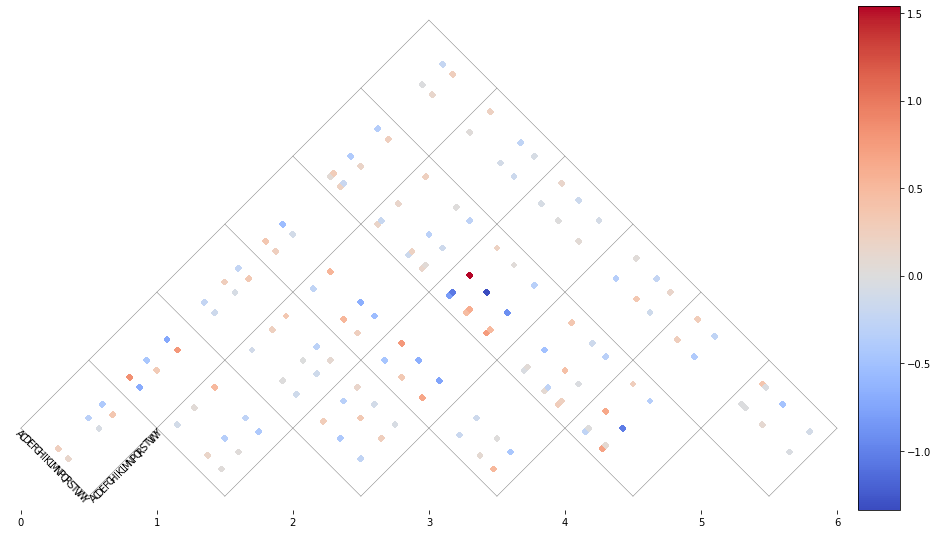

In [10]:
##Loading Bk79 data, training and plotting
train_set, test_set = LoadData('../result/NA_compile_results.tsv','Bk79')
print(train_set)
model = Train_model(train_set,test_set,0.1,0.05,64)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
model.save('../result/Bk79_epi')
#model = mavenn.load('../result/Bk79_epi')

## Plot epistasis
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10])          
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
#save epistasis and additive
data = theta['theta_lclc']
theta_lc=theta['theta_lc']
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/Bk79_epi.csv')
print(epi_df)
add_df=reformat(theta_lc)
add_df.to_csv('../result/Bk79_add.csv')
print(add_df)

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


     index       ID strain        pI  charge  rep1_fit  rep2_fit       fit  \
0     2463  NSKSEKS  Bei89  7.417786       1  0.217356  0.117935  0.167646   
1     2169  KDRGETL  Bei89  7.066467       0  0.359625  0.182533  0.271079   
2     2072  NSESKDS  Bei89  6.777405      -1  1.368789  0.760288  1.064538   
3     2461  NNRGKDS  Bei89  7.418396       1  0.192259  0.178495  0.185377   
4     2433  KSRSEEL  Bei89  7.066956       0  1.096812  1.243373  1.170093   
..     ...      ...    ...       ...     ...       ...       ...       ...   
686   2573  KNKGKTS  Bei89  7.961853       3  0.086038  0.097271  0.091654   
687   2430  KSEGEDS  Bei89  6.556580      -2  1.430472  0.722482  1.076477   
688   2106  KSENETL  Bei89  6.778015      -1  2.617391  2.643739  2.630565   
689   2049  KSRSEES  Bei89  7.066956       0  0.737836  0.893774  0.815805   
690   1752  NSESETS  Bei89  6.555969      -2  2.246750  2.258795  2.252773   

            y    set  
0   -1.785903  train  
1   -1.305345  tr

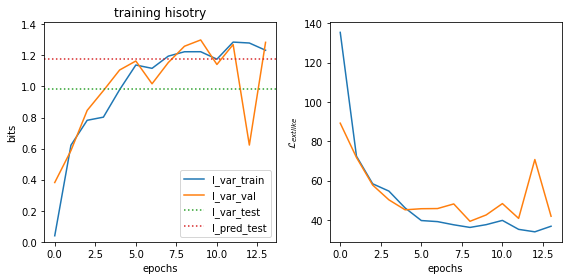

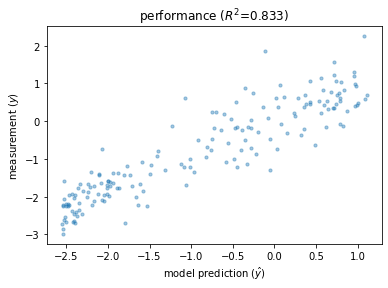

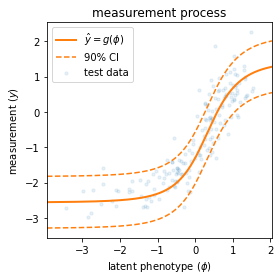

Model saved to these files:
	../result/Bei89_epi.pickle
	../result/Bei89_epi.h5
      L1   L2 AA1 AA2       EPI
0    1.0  2.0   K   D  0.058237
1    1.0  2.0   K   N -0.046421
2    1.0  2.0   K   S -0.119693
3    1.0  2.0   N   D  0.010193
4    1.0  2.0   N   N  0.075174
..   ...  ...  ..  ..       ...
148  6.0  7.0   E   S  0.109594
149  6.0  7.0   K   L -0.180074
150  6.0  7.0   K   S -0.298863
151  6.0  7.0   T   L -0.076187
152  6.0  7.0   T   S  0.077662

[153 rows x 5 columns]
    pos aa   add_fit
0   328  K -0.105215
1   328  N  0.075750
2   329  D  0.059349
3   329  N  0.024072
4   329  S -0.195493
5   344  E  0.294083
6   344  K -0.124200
7   344  R -0.147045
8   367  G -0.292944
9   367  N  0.104115
10  367  S  0.095714
11  368  E  0.382842
12  368  K -0.473038
13  369  D  0.283321
14  369  E  0.191059
15  369  K -0.491811
16  369  T -0.002515
17  370  L -0.030313
18  370  S -0.077688


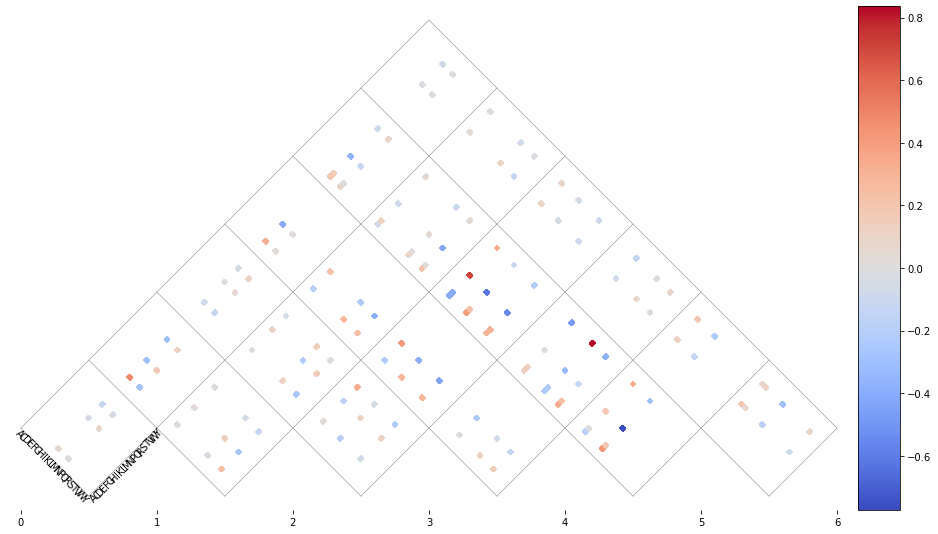

In [11]:
##Loading Bei89 data, training and plotting
train_set, test_set = LoadData('../result/NA_compile_results.tsv','Bei89')
print(train_set)
model = Train_model(train_set,test_set,0.8,0.05,64)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
model.save('../result/Bei89_epi')
#model = mavenn.load('../result/Bei89_epi')

## Plot epistasis
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10])          
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
#save epistasis and additive
data = theta['theta_lclc']
theta_lc=theta['theta_lc']
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/Bei89_epi.csv')
print(epi_df)
add_df=reformat(theta_lc)
add_df.to_csv('../result/Bei89_add.csv')
print(add_df)

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


     index       ID strain        pI  charge  rep1_fit  rep2_fit       fit  \
0     2596  NNRNEKS  Mos99  6.377380       1  0.361026  0.461285  0.411155   
1     2758  NDRNKKS  Mos99  6.555603       2  0.152195  0.254494  0.203345   
2     3152  NDKGKDS  Mos99  6.224060       0  0.795200  0.765180  0.780190   
3     3008  NNRGKES  Mos99  6.377380       1  0.238298  0.277507  0.257902   
4     2862  KDRSKEL  Mos99  6.378113       1  0.783838  0.611785  0.697812   
..     ...      ...    ...       ...     ...       ...       ...       ...   
686   2740  KSEGKTS  Mos99  6.377380       1  0.342169  0.370881  0.356525   
687   2858  NDENEKS  Mos99  5.967834      -2  1.279452  1.359527  1.319490   
688   2792  NNESKKL  Mos99  6.377380       1  0.263415  0.160887  0.212151   
689   2804  KDRSKKS  Mos99  6.777527       3  0.077311  0.080628  0.078969   
690   3125  NSKNKTL  Mos99  6.554993       2  0.301706  0.202619  0.252163   

            y    set  
0   -0.888784  train  
1   -1.592853  tr

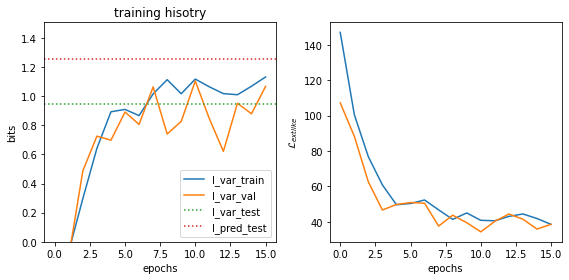

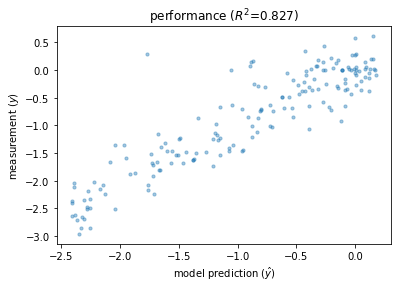

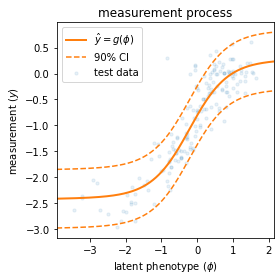

Model saved to these files:
	../result/Mos99_epi.pickle
	../result/Mos99_epi.h5
      L1   L2 AA1 AA2       EPI
0    1.0  2.0   K   D  0.109294
1    1.0  2.0   K   N  0.023788
2    1.0  2.0   K   S -0.187239
3    1.0  2.0   N   D  0.041164
4    1.0  2.0   N   N -0.117140
..   ...  ...  ..  ..       ...
148  6.0  7.0   E   S  0.109876
149  6.0  7.0   K   L -0.072201
150  6.0  7.0   K   S -0.234074
151  6.0  7.0   T   L  0.057272
152  6.0  7.0   T   S  0.037276

[153 rows x 5 columns]
    pos aa   add_fit
0   328  K -0.083732
1   328  N  0.019597
2   329  D  0.191612
3   329  N -0.148485
4   329  S -0.066843
5   344  E  0.075680
6   344  K -0.062459
7   344  R -0.070521
8   367  G -0.072185
9   367  N -0.028987
10  367  S  0.061891
11  368  E  0.312647
12  368  K -0.337554
13  369  D  0.138839
14  369  E  0.123774
15  369  K -0.351681
16  369  T  0.064274
17  370  L  0.096676
18  370  S -0.023751


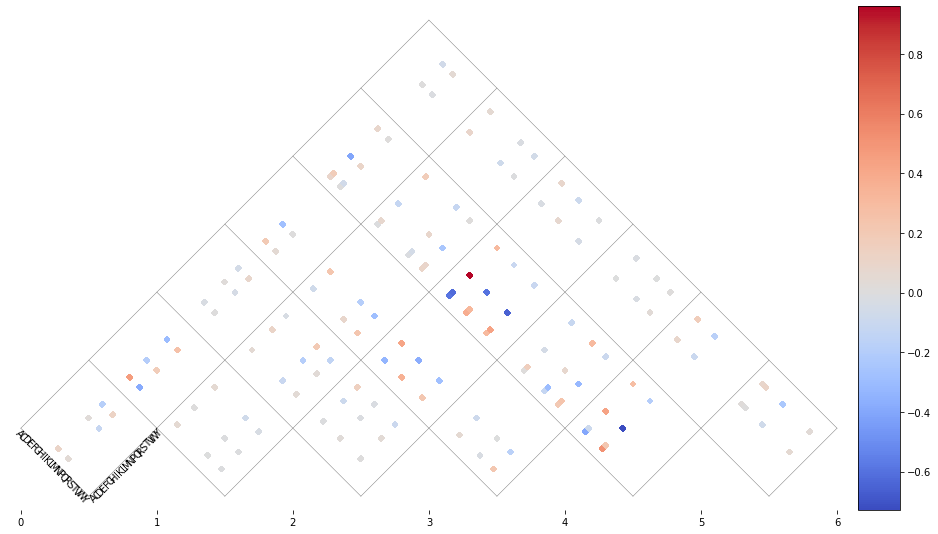

In [13]:
##Loading Mos99 data, training and plotting
train_set, test_set = LoadData('../result/NA_compile_results.tsv','Mos99')
print(train_set)
model = Train_model(train_set,test_set,0.8,0.05,64)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
model.save('../result/Mos99_epi')
#model = mavenn.load('../result/Mos99_epi')

## Plot epistasis
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10])          
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
#save epistasis and additive
data = theta['theta_lclc']
theta_lc=theta['theta_lc']
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/Mos99_epi.csv')
print(epi_df)
add_df=reformat(theta_lc)
add_df.to_csv('../result/Mos99_add.csv')
print(add_df)

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


     index       ID strain        pI  charge  rep1_fit  rep2_fit       fit  \
0     3469  KDESEES  Vic11  6.095276      -3  0.778803  0.818360  0.798582   
1     3959  NSESEES  Vic11  6.094177      -3  0.307496  0.373720  0.340608   
2     3541  NDRNEES  Vic11  6.228088      -2  0.409712  0.298225  0.353969   
3     3928  NSKNEDL  Vic11  6.378601      -1  1.242906  1.304011  1.273458   
4     3692  KNEGKES  Vic11  6.558655       0  0.229267  0.173646  0.201457   
..     ...      ...    ...       ...     ...       ...       ...       ...   
686   3742  NSENKKS  Vic11  6.779846       1  0.409995  0.328676  0.369335   
687   4040  KDRGETS  Vic11  6.557800       0  0.746060  0.530562  0.638311   
688   4199  NSRGKDL  Vic11  6.779358       1  0.091812  0.149765  0.120788   
689   3947  KDRNEKL  Vic11  6.780334       1  0.770565  0.525914  0.648240   
690   3614  KSKGKKL  Vic11  7.746155       4  0.120669  0.083474  0.102071   

            y    set  
0   -0.224918  train  
1   -1.077022  tr

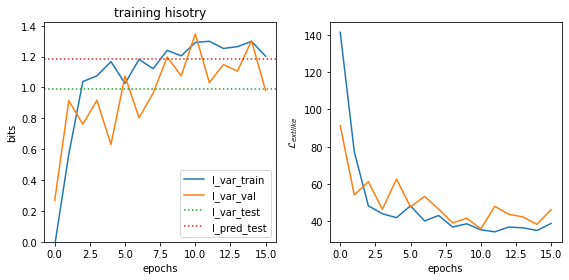

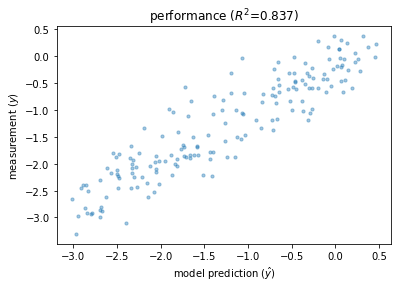

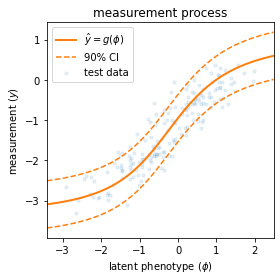

Model saved to these files:
	../result/Vic11_epi.pickle
	../result/Vic11_epi.h5
      L1   L2 AA1 AA2       EPI
0    1.0  2.0   K   D  0.354267
1    1.0  2.0   K   N -0.141884
2    1.0  2.0   K   S -0.168446
3    1.0  2.0   N   D -0.199271
4    1.0  2.0   N   N  0.107921
..   ...  ...  ..  ..       ...
148  6.0  7.0   E   S -0.075515
149  6.0  7.0   K   L  0.014108
150  6.0  7.0   K   S -0.097389
151  6.0  7.0   T   L -0.153627
152  6.0  7.0   T   S  0.167030

[153 rows x 5 columns]
    pos aa   add_fit
0   328  K  0.010343
1   328  N -0.069256
2   329  D  0.225213
3   329  N -0.074065
4   329  S -0.100441
5   344  E  0.087266
6   344  K -0.026163
7   344  R -0.011700
8   367  G -0.246238
9   367  N  0.180985
10  367  S  0.085726
11  368  E  0.260001
12  368  K -0.272410
13  369  D  0.235295
14  369  E -0.125115
15  369  K -0.094290
16  369  T -0.000492
17  370  L -0.121602
18  370  S  0.133505


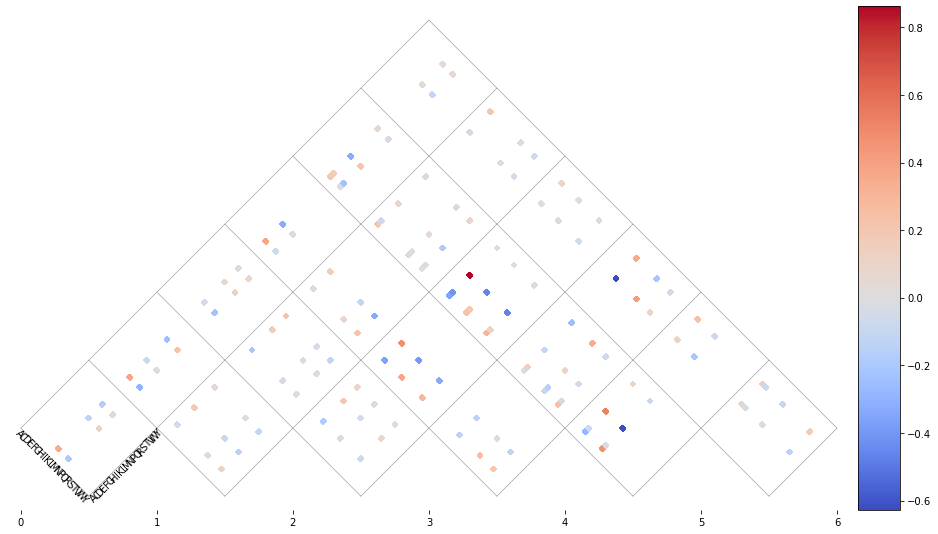

In [14]:
##Loading Vic11 data, training and plotting
train_set, test_set = LoadData('../result/NA_compile_results.tsv','Vic11')
print(train_set)
model = Train_model(train_set,test_set,0.8,0.05,64)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
model.save('../result/Vic11_epi')
#model = mavenn.load('../result/Vic11_epi')

## Plot epistasis
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10])          
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
#save epistasis and additive
data = theta['theta_lclc']
theta_lc=theta['theta_lc']
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/Vic11_epi.csv')
print(epi_df)
add_df=reformat(theta_lc)
add_df.to_csv('../result/Vic11_add.csv')
print(add_df)

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


     index       ID strain        pI  charge  rep1_fit  rep2_fit       fit  \
0     4322  KSRGEES   HK19  6.424011       0  0.788602  0.733663  0.761132   
1     4723  KDRNEDL   HK19  6.275696      -1  2.268154  1.538617  1.903386   
2     5028  KNEGETS   HK19  6.276184      -1  0.806427  0.530401  0.668414   
3     4655  NDENETL   HK19  6.025818      -3  0.412392  0.760578  0.586485   
4     4557  NDESKDL   HK19  6.144348      -2  0.503740  0.753957  0.628848   
..     ...      ...    ...       ...     ...       ...       ...       ...   
686   4722  KDKGETL   HK19  6.422913       0  0.369596  0.303265  0.336430   
687   4524  KDESETL   HK19  6.145935      -2  2.232801  1.212440  1.722620   
688   4437  NNKGEES   HK19  6.276184      -1  1.007173  0.552971  0.780072   
689   4535  KNKSKKS   HK19  7.438293       4  0.097029  0.199599  0.148314   
690   4936  KDESKKL   HK19  6.596985       1  0.338920  0.670033  0.504476   

            y    set  
0   -0.272948  train  
1    0.643634  tr

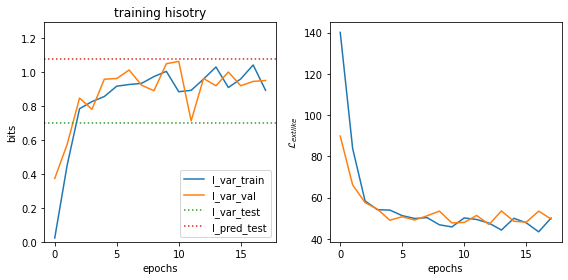

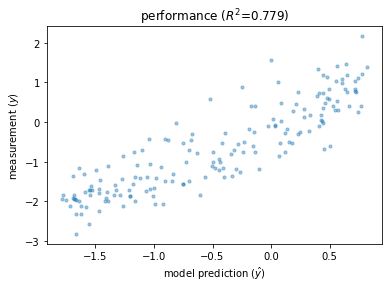

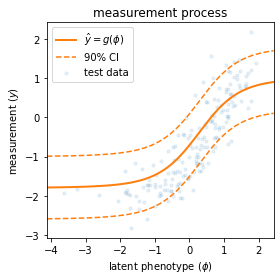

Model saved to these files:
	../result/HK19_epi.pickle
	../result/HK19_epi.h5
      L1   L2 AA1 AA2       EPI
0    1.0  2.0   K   D  0.234750
1    1.0  2.0   K   N -0.209382
2    1.0  2.0   K   S -0.049512
3    1.0  2.0   N   D -0.016802
4    1.0  2.0   N   N -0.018840
..   ...  ...  ..  ..       ...
148  6.0  7.0   E   S -0.069028
149  6.0  7.0   K   L -0.093887
150  6.0  7.0   K   S -0.081706
151  6.0  7.0   T   L -0.052266
152  6.0  7.0   T   S  0.117775

[153 rows x 5 columns]
    pos aa   add_fit
0   328  K  0.016784
1   328  N  0.052261
2   329  D  0.301100
3   329  N -0.336368
4   329  S -0.103757
5   344  E  0.026525
6   344  K -0.026111
7   344  R -0.035747
8   367  G -0.311260
9   367  N  0.121553
10  367  S  0.230237
11  368  E  0.245340
12  368  K -0.287133
13  369  D  0.172331
14  369  E -0.050226
15  369  K -0.227740
16  369  T  0.052950
17  370  L -0.202329
18  370  S  0.082809


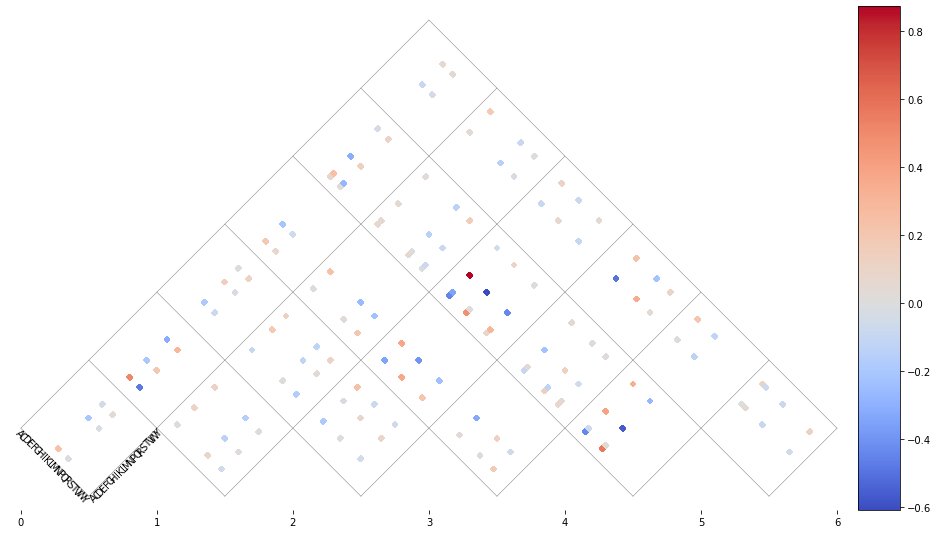

In [20]:
##Loading HK19 data, training and plotting
train_set, test_set = LoadData('../result/NA_compile_results.tsv','HK19')
print(train_set)
model = Train_model(train_set,test_set,0.8,0.05,64)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
model.save('../result/HK19_epi')
#model = mavenn.load('../result/HK19_epi')

## Plot epistasis
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10])          
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
#save epistasis and additive
data = theta['theta_lclc']
theta_lc=theta['theta_lc']
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/HK19_epi.csv')
print(epi_df)
add_df=reformat(theta_lc)
add_df.to_csv('../result/HK19_add.csv')
print(add_df)